# Time Series Predicting using LSTMs with TensorFlow in Python

Time series forecasting is a crucial aspect of various real-world applications, from financial market prediction to weather forecasting and demand planning. Accurate forecasting enables better decision-making and strategic planning. Among the many techniques available for time series forecasting, neural networks, particularly Long Short-Term Memory (LSTM) networks, have gained significant popularity due to their ability to capture long-term dependencies in sequential data.

This project aims to demonstrate how to prepare time series data and utilize LSTM networks for forecasting using a simple yet illustrative example—sine wave data generated using the np.sin function. The sine wave, being periodic and continuous, serves as an ideal candidate for exploring the nuances of time series forecasting.

**Objectives**
The primary objectives of this project are:

**Data Generation and Preparation:**

- Generate sine wave data using the np.sin function.
- Split the data into training and testing sets with an 80:20 ratio.
- Create input (X) and output (y) datasets for both single-step and multi-step predictions.
  
**Forecasting Approaches:**

- Single Prediction: Predict one timestep into the future given a warm-up period.
- Multiple Predictions using Autoregressive Method: Predict multiple future timesteps by iteratively using the predicted values as inputs for subsequent predictions. This method simulates real-world scenarios where future values must be forecasted without access to actual future data.

**Model Building:**

- Construct an LSTM-based neural network model using TensorFlow.
- Train the model on the prepared datasets.
- Prediction and Forecasting:
  - Use the trained model to predict future values.
  - Employ the autoregressive method to forecast a sequence of future values based on initial predictions.


# 1.  Importing libraries 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import IPython
import IPython.display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 43

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


2024-07-22 16:47:51.929539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Data Generation and Preparation

## 2.1 Data generation

We generate a sine wave dataset with added noise, consisting of 1,000 examples. This dataset is then split into a training set of 800 examples and a test set of 200 examples

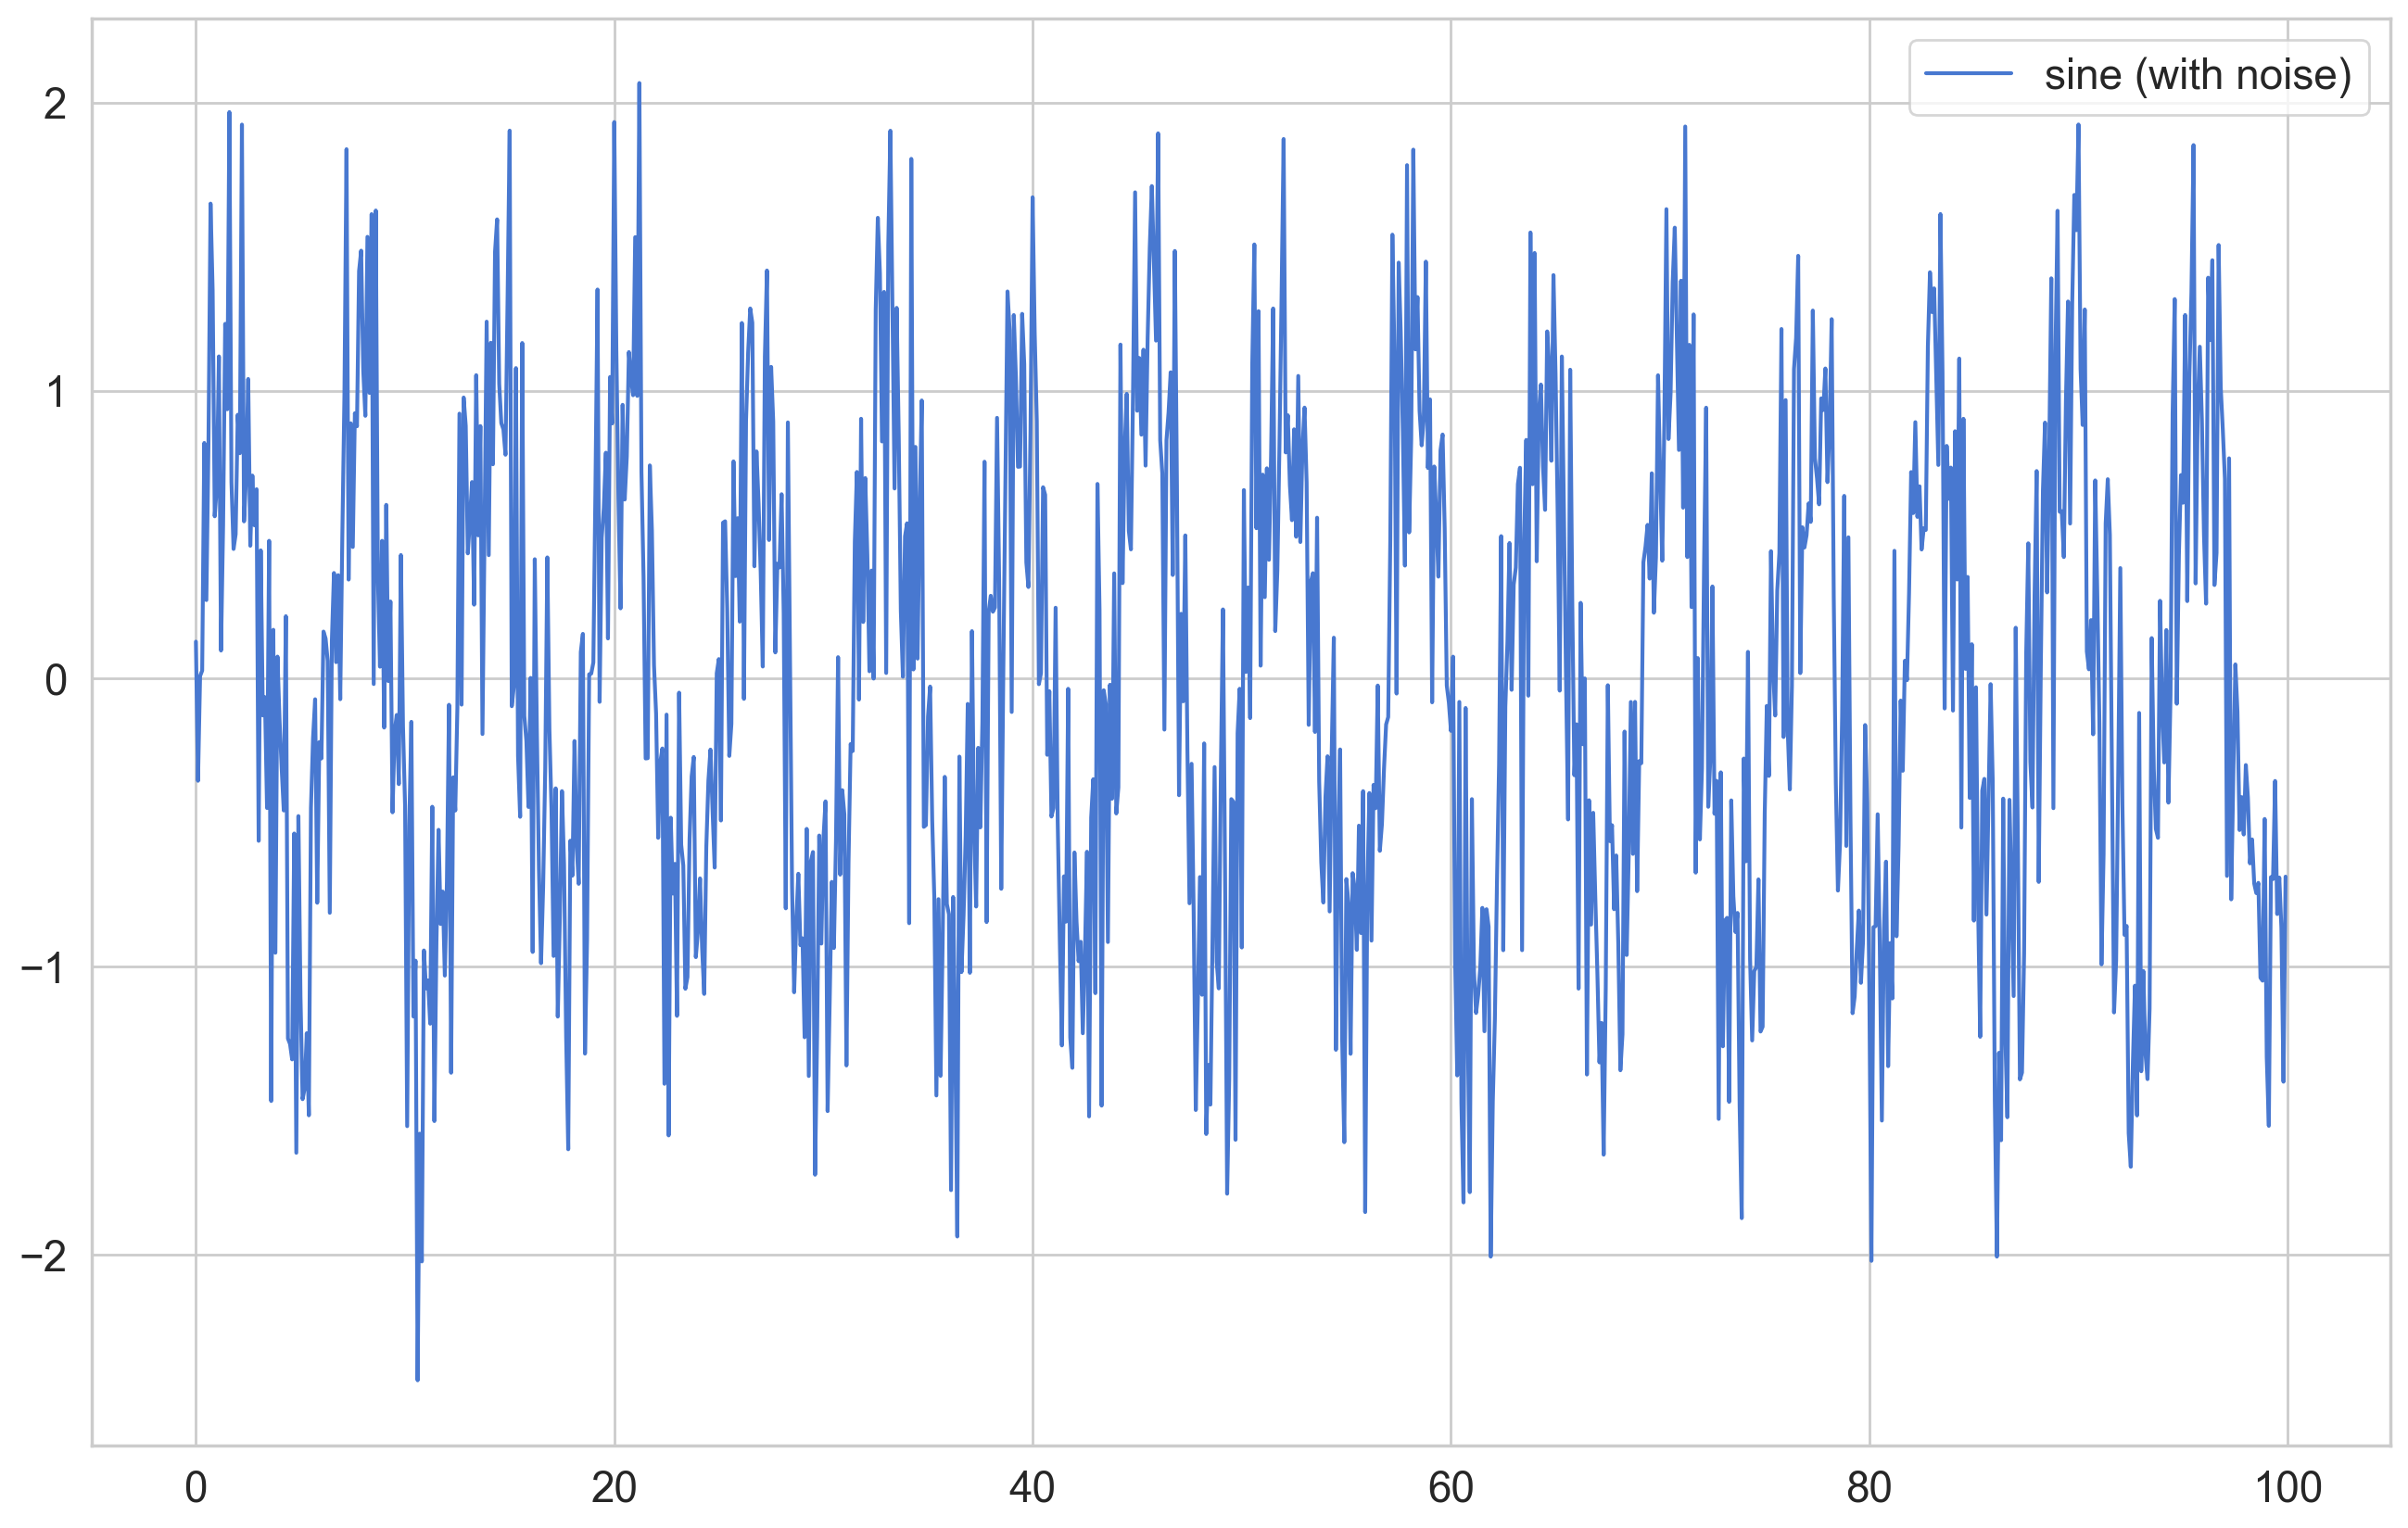

In [2]:
time = np.arange(0, 100, 0.1)
sin = np.sin(time) + np.random.normal(scale = 0.5, size = len(time))

# Plot the generated data
plt.plot(time, sin, label = 'sine (with noise)')
plt.legend()
plt.show()

In [3]:
# create a dataframe and split the data into train and test sets
df = pd.DataFrame(dict(sine = sin), index = time, columns = ['sine'])

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(f"""Length of traing data: {len(train)}
Length of test data: {len(test)}""")

Length of traing data: 800
Length of test data: 200


## 2.2 Data Preparation:

**1. Single Time-Step Prediction:**

- **Objective:** To predict values for a single time-step into the future.
    
- **Configurations:**

    - For a short-term prediction, set label_width = 1 and shift = 1. For instance, given a history of 40 time-steps (from $t=0$ to $t=40$, the model will predict the value at $t=41$ (1 time-step into the future).
    - For a long-term prediction, set label_width = 1 and shift = 50. In this case, using the same history, the model will forecast the value at $t=90$ (50 time-steps into the future).
        
**2. Multiple Time-Step Predictions:**
- **Objective:** To predict multiple time-steps into the future, where the number of time-steps predicted (label width) is greater than 1 but less than the shift.
- **Configuration:**
  - For instance, if label_width = 40 and shift = 40, with an input_width also set to 40, the model will generate predictions for the next 40 time-steps into the future based on the initial 40 time-steps of history. This setup tests the model's ability to understand and forecast both short and long sequences, revealing how well it captures patterns over varying future horizons.

The figure below illustrates how we create the inputs and labels for training purposes:

![Slicing window and splitting data](images/slicing_window.png)
 Image credit: [Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)


This figure applies on the second instance where we aim for long-term prediction with parameters set as input_width = 40, label_width = 1, and shift = 50, resulting in a window size of 90. With a total of 800 time-steps in our training data, the first window slicing will be from t=0 to t=89. The second window is from t=1 to t=90, and so on. For each window, we need to split it into input (X) and label (y) sets. For each example (for each window), we will use the first 40 time-steps as inputs and the 90th time-step as the label.



In [4]:

def create_dataset(X, input_width, label_width, shift, test = False):
    """
    X: dataframe
    input_width: Number of history time-steps
    label_width: Number of time-steps we want to predict into the future
    shift: number of time steps between the last time step in input and last time step in the labels
    test: boolean-if True, the type_data is a test set. This is for printing shape of data
    """
    
    window_size = input_width + shift
    
    inputs, labels = [], []
    for i in range(len(X) - window_size + 1):
        window = X.iloc[i:(i+window_size)] #slice the window

        x = window.iloc[:input_width]
        inputs.append(x)
        y = window.iloc[(window_size-label_width):, :]
        # print(i, s.shape)
        labels.append(y)
    if test:
        type_data = 'test'
    else:
        type_data = 'train'
    print(f"""Shape of {type_data} data: {(np.array(inputs)).shape, (np.array(labels)).shape}""")
    return np.array(inputs), np.array(labels)

In [5]:
"""
Define a window_params dictionary to store (input_width, label_width, shift) parameters. We want to explore these cases:
- Single output where the model is given no historical information(input size or input_width =1)
- Single output where the model is given a history of 40 time-steps and predict 10 time-step into the future.
- Single output where the model is given a history of 40 time-steps and predict 50 time-step into the future.

- Multiple outputs where the model is given 40 time-steps in the past and asked to predict the next 40 time-steps
- Multiple outputs where the model is given 40 time-steps in the past and asked to predict the next 120 time-steps
into the future (long sequence prediction) We want to see if the model is capable of predicting long sequence data.

We will also define val_performance and test_performance to store the models' performance.
"""
window_params = {'single_output': ((1, 1, 1), (40, 1, 10), (40, 1, 50)), 'multi-output': ((40, 40, 40), (40 , 120, 120)) }
val_performance, test_performance = {}, {}





**In the following steps, we will build models to train and predict future time steps. This process involves defining the model, compiling it, and then fitting it on the training dataset. Since this process will be repeated, we will encapsulate the model compilation and training steps within a function for convenience.**





In [6]:
def compile_and_fit(model, data, params, patience = 2):
    """
    model - neural network model
    data - a tuple contain X and y
    params: a tuple contains hyperparameters (learning rate, epochs)
    return model after compile and fitting
    """
    X_train, y_train = data
    lr, MAX_EPOCHS = params
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                     patience = patience,
                                                     mode = 'min')
    model.compile(loss = tf.keras.losses.MeanSquaredError(),
                 optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                 metrics = [tf.keras.metrics.MeanAbsoluteError()])
    history = model.fit(X_train,
                       y_train,
                       epochs = MAX_EPOCHS,
                       validation_split = 0.1,
                       callbacks = [early_stopping])
    return history

def get_datasets(train, test, params):
    """
    train: data frame of train set
    test: data frame of test set
    params: tuple of (input_width, label_width, shift)
    return: X_tr: X train, y_tr: y_train, X_tst: X_test, y_tst: y_test
    """
    input_width, label_width, shift = params
    X_tr, y_tr = create_dataset(train, input_width, label_width, shift)
    X_tst, y_tst = create_dataset(test, input_width, label_width, shift, test = True)
    return X_tr, y_tr, X_tst, y_tst

# 3. Building and training models

There are two primary approaches for predicting future values in time series forecasting:
1. **Open-Loop Model:** This approach uses the actual data at time step $t$ to predict the value at time step $t+1$. By relying on real values, the open-loop model generally provides more accurate predictions since it bases its forecasts on true observations.
2. **Closed-Loop Model:** In this approach, the model uses predicted values from previous time steps to forecast future values. Specifically, the predicted value at time step $t$ is used to predict the value at time step $t+1$. This method is particularly useful when real values are not available, as it allows for forecasting future values based on the model’s own predictions.

In practice, while the open-loop model often yields more accurate results due to its reliance on actual data, the closed-loop model is necessary in scenarios where future real values cannot be obtained.

This project will implement and compare both approaches using the dataset to evaluate their performance and applicability.

Throughout the training, we will use consistent hyperparameters for all models to ensure comparability. Specifically, we will set the number of units to 32 and the learning rate to 0.001 for all models.



In [7]:
num_features = 1 # number of feature or columns. Here we have only one feature, so we make it as our default value
def OpenModel(units):
    """
    Open model with 2 layers:
    - LSTM layer
    - Dense layer: output
    """
    lstm_model = tf.keras.models.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(units))
    lstm_model.add(tf.keras.layers.Dense(num_features))
    return lstm_model
    
class FeedBack(tf.keras.Model):
    """
    Feedback class: using autoregressive approach that take previous prediction as inputs
    for next prediction.
    """
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state = True)
        self.dense = tf.keras.layers.Dense(num_features)

def warmup(self, inputs):
    """
    given a warmup inputs period, we will predict the next timestep, return the prediction
    and its current state.
    """
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup


def call(self, inputs, training = None):
    """
    For each example, the model take in a warmup inputs, return the current state and
    the prediction for the next output.
    In the for loop, the model will take the previous prediction as its input,
    calculate the current state and predict the value for the next timestep. 
    """
    predictions = []
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)

    for n in range(1, self.out_steps):
        x = prediction

        x, state = self.lstm_cell(x, states = state,
                                 training = training)
        prediction = self.dense(x)
        predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

## 3.1 Single prediction

### 3.1.1 label_width = 1

In this model, the task is to predict the value at time step $t+1$ given the value at time step $t$. In this scenario, the input consists of a single time step, which provides no context about how the feature changes over time.

Later, we will extend this approach to single-step predictions where the label width is greater than 1 (i.e., the input width is larger than 2). This means we will provide additional context about the feature's behavior over multiple time steps. We anticipate that this approach will improve prediction accuracy compared to the simpler case where the input width is only 1.

After splitting the data, there are 799 examples in the train set and 199 example in the test set.

Each input example has shape (1, 1) and corresponds to a real label of shape (1, 1). The model will be trained to take in the input and predict the value of the next time step:

![](images/window_2.png) 

Image credit: [Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)


In [8]:
"""
Retrieve the parameters and create train and test sets
Recall: window_params = {'single_output': ((1, 1, 1), (40, 1, 10), (40, 1, 50)), 'multi-output': ((40, 40, 40), (40 , 120, 120)) }
"""
single_params = window_params['single_output'][0]
X_train, y_train, X_test, y_test = get_datasets(train, test, single_params)

Shape of train data: ((799, 1, 1), (799, 1, 1))
Shape of test data: ((199, 1, 1), (199, 1, 1))


In [9]:
"""
train the model
"""
data = (X_train, y_train)
lr, MAX_EPOCHS = 0.001, 100
params = (lr, MAX_EPOCHS)
open_model_2 = OpenModel(32)
history_open_2 = compile_and_fit(open_model_2, data, params)
IPython.display.clear_output()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


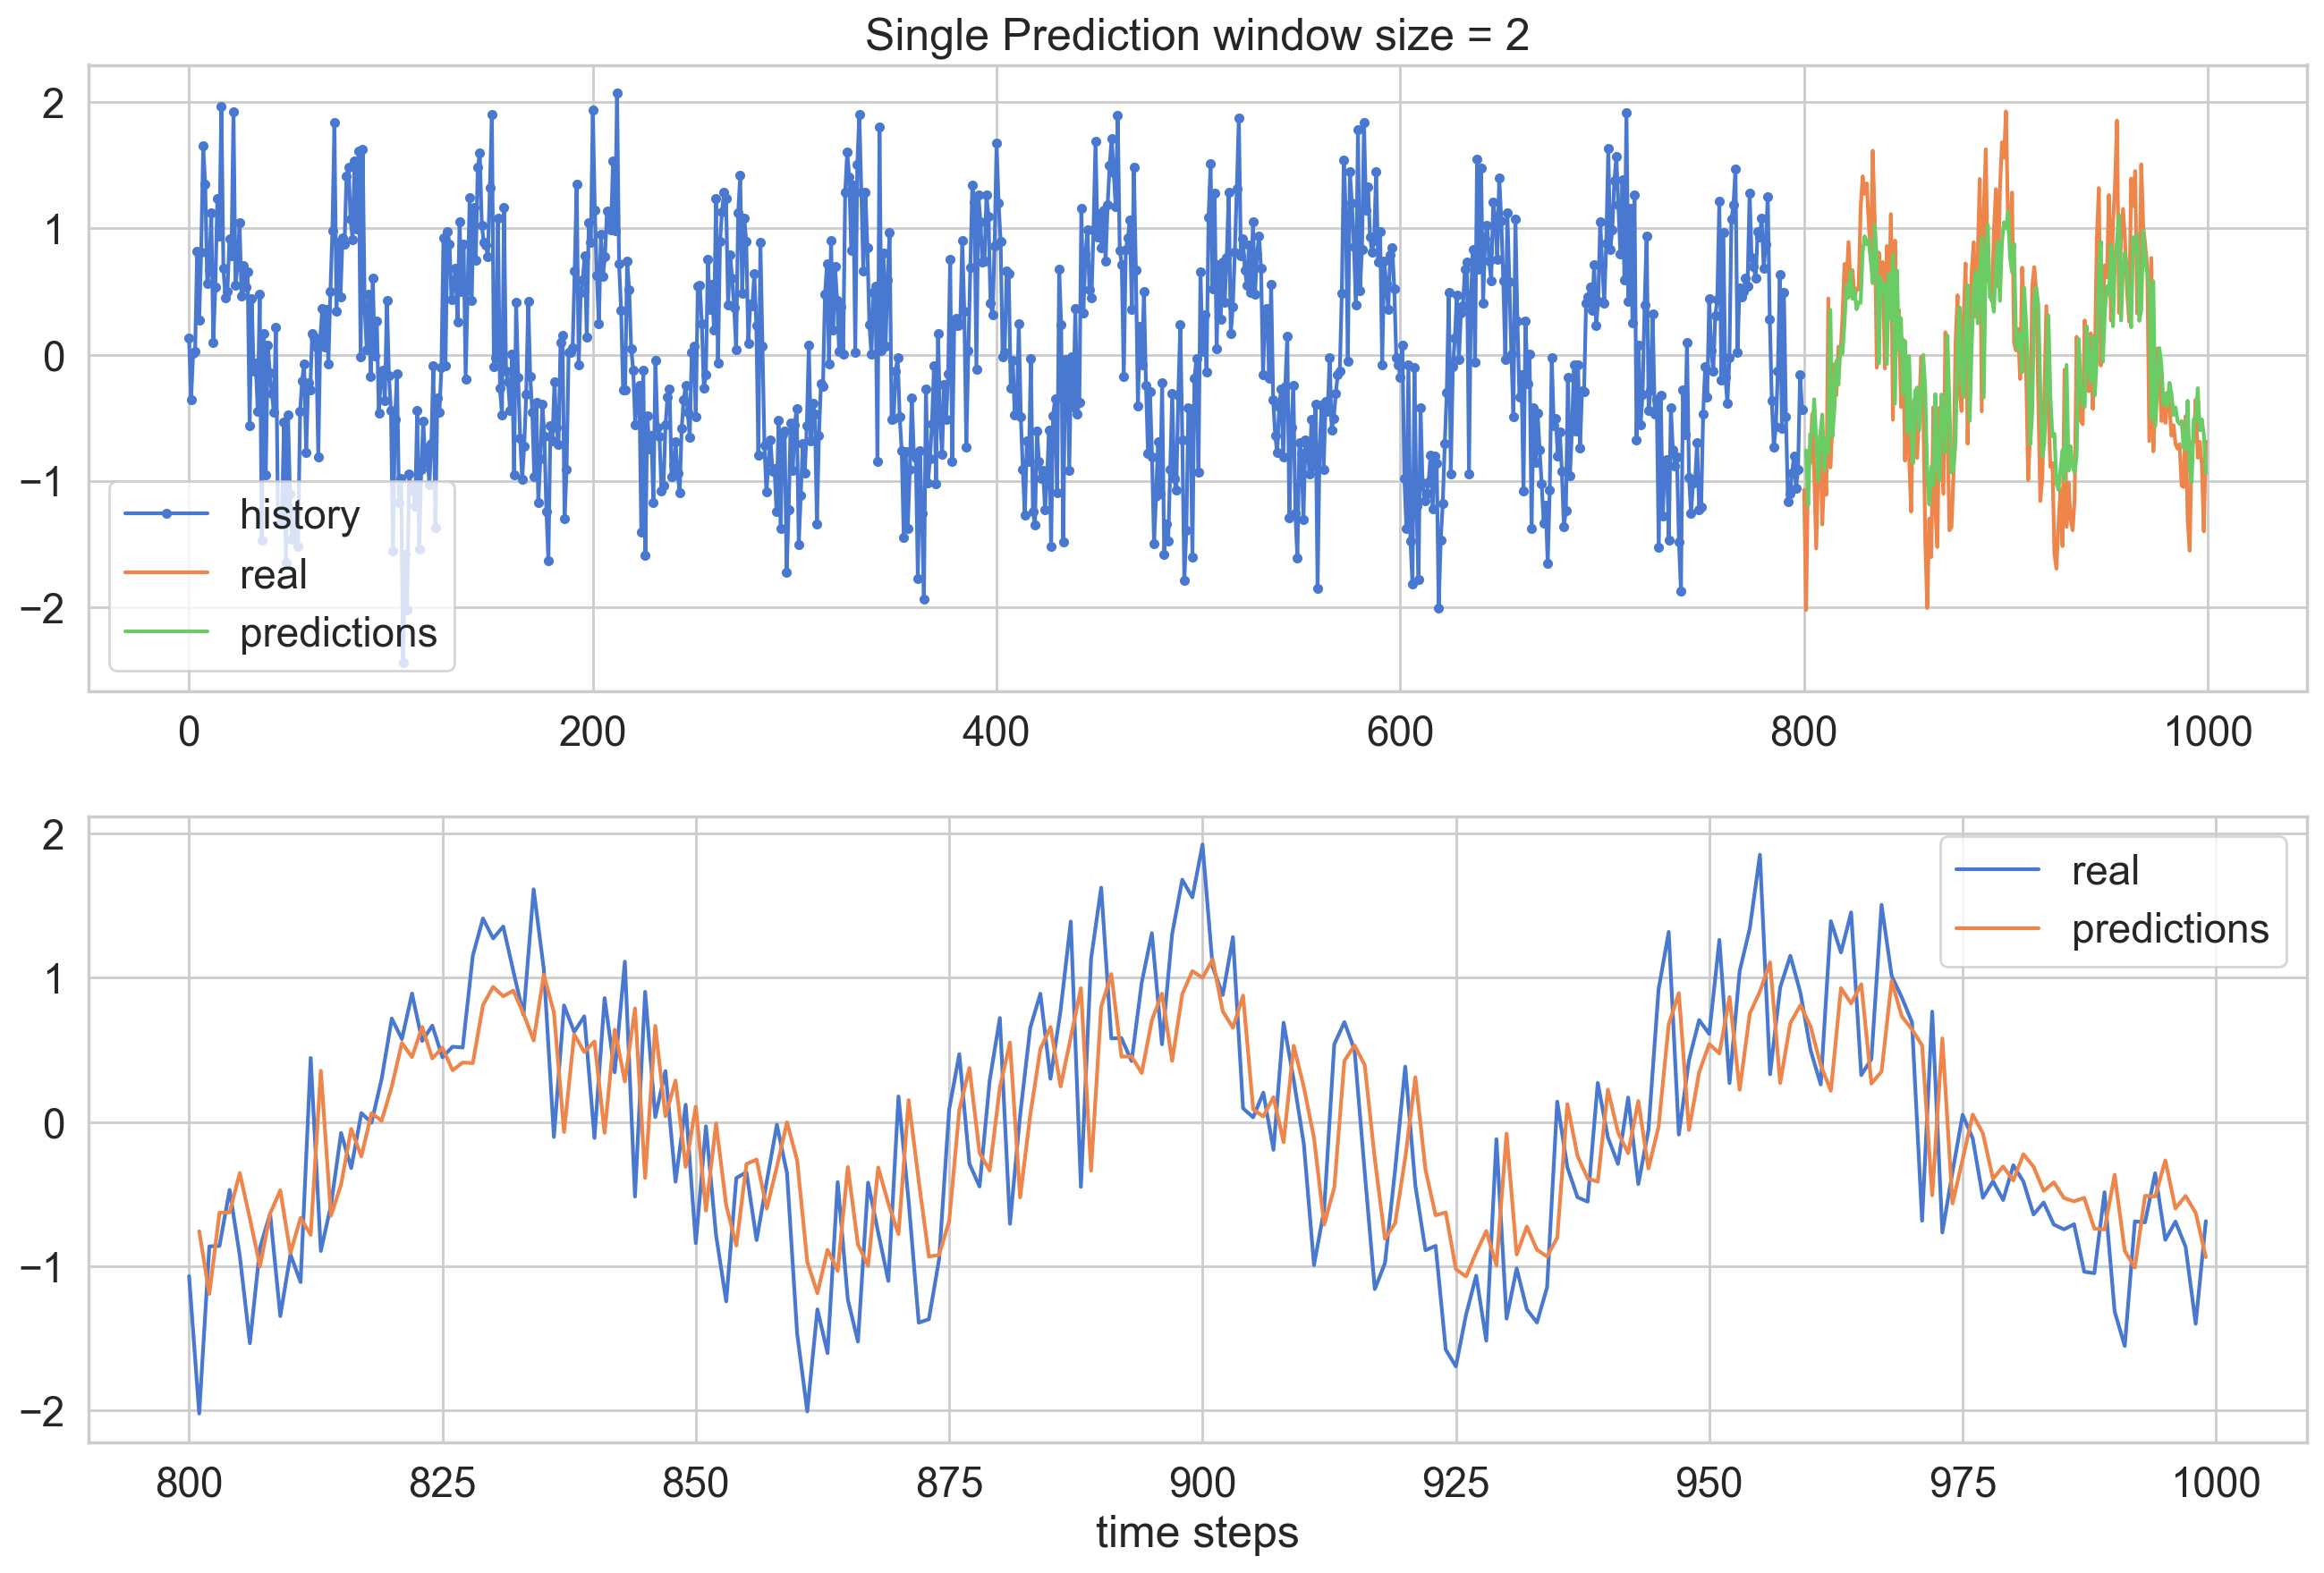

In [10]:
"""
Now that we have trained model, we will predict the X_test and plot it against y_test
We will plot the whole time series (both train and test set) plus the prediction for the test set.
To see better the predictions vs real vlaue, we will plot just the test set against the prediction
"""
def open_plot(df1, df2, df3, window_size, title):
    plt.subplot(2, 1, 1)
    plt.plot([i for i in range(len(df1))], df1, label = 'history', marker = '.')
    plt.plot([i for i in range(len(df1), len(df1)+len(df2))], df2, label = 'real')
    plt.plot([i for i in range(len(df1)+ window_size-1, len(df1)+df3.shape[0]+ window_size-1)], df3, label = 'predictions')
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot([i for i in range(len(df1), len(df1)+len(df2))], df2, label = 'real')
    plt.plot([i for i in range(len(df1)+ window_size-1, len(df1)+df3.shape[0]+ window_size-1)], df3, label = 'predictions')
    plt.xlabel('time steps')
    plt.legend()
    plt.show()

    
open_predict_2 = open_model_2.predict(X_test)
test_performance['open_model_2'] = open_model_2.evaluate(X_test, y_test, verbose = 0, return_dict = True)

open_plot(train.sine, test.sine, open_predict_2, window_size = 2, title = f'Single Prediction window size = 2')


Overall, the model appears to effectively capture the general pattern of the data, particularly the sine wave. However, it struggles to account for random fluctuations, leading to higher error compared to other models (which we will explore later). This limitation arises because the model relies on predictions based solely on a single timestep. Without additional context, it cannot discern how the data evolves over time. For instance, while the initial prediction is close to the input value (the previous timestep), it diverges significantly from the actual value.



### 3.1.2. label_width = 40, shift = 10

Now, we will give some context to the current value at time step t, and we want to predict 10 time-steps into the future.

We will use label_width = 40, and shift = 10: given 40 time-steps, we want to predict the value at the 50th time-step.


After splitting the data, there are 751 examples in the train set and 151 example in the test set.

Each input example has shape (40, 1) and corresponds to a real label of shape (1, 1). The model will be trained to take in the input of length 40 and predict the value of 10 steps into the future:

![](images/window_50.png)

Image credit: [Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)


In [11]:
"""
Retrieve the parameters and create train and test sets
"""
single_params = window_params['single_output'][1]
X_train, y_train, X_test, y_test = get_datasets(train, test, single_params)
print(f'single_params: {single_params}')

Shape of train data: ((751, 40, 1), (751, 1, 1))
Shape of test data: ((151, 40, 1), (151, 1, 1))
single_params: (40, 1, 10)


In [12]:
"""
Training the data on single prediction window size of 50.
Note that I renamed the open_model to open_model_50 to distinguish the two model. 50 implies window size.
All the hyperparameters are same for comparision purposes.
"""
data = (X_train, y_train)
open_model_50 = OpenModel(32)
history_open_50 = compile_and_fit(open_model_50, data, params)
IPython.display.clear_output()

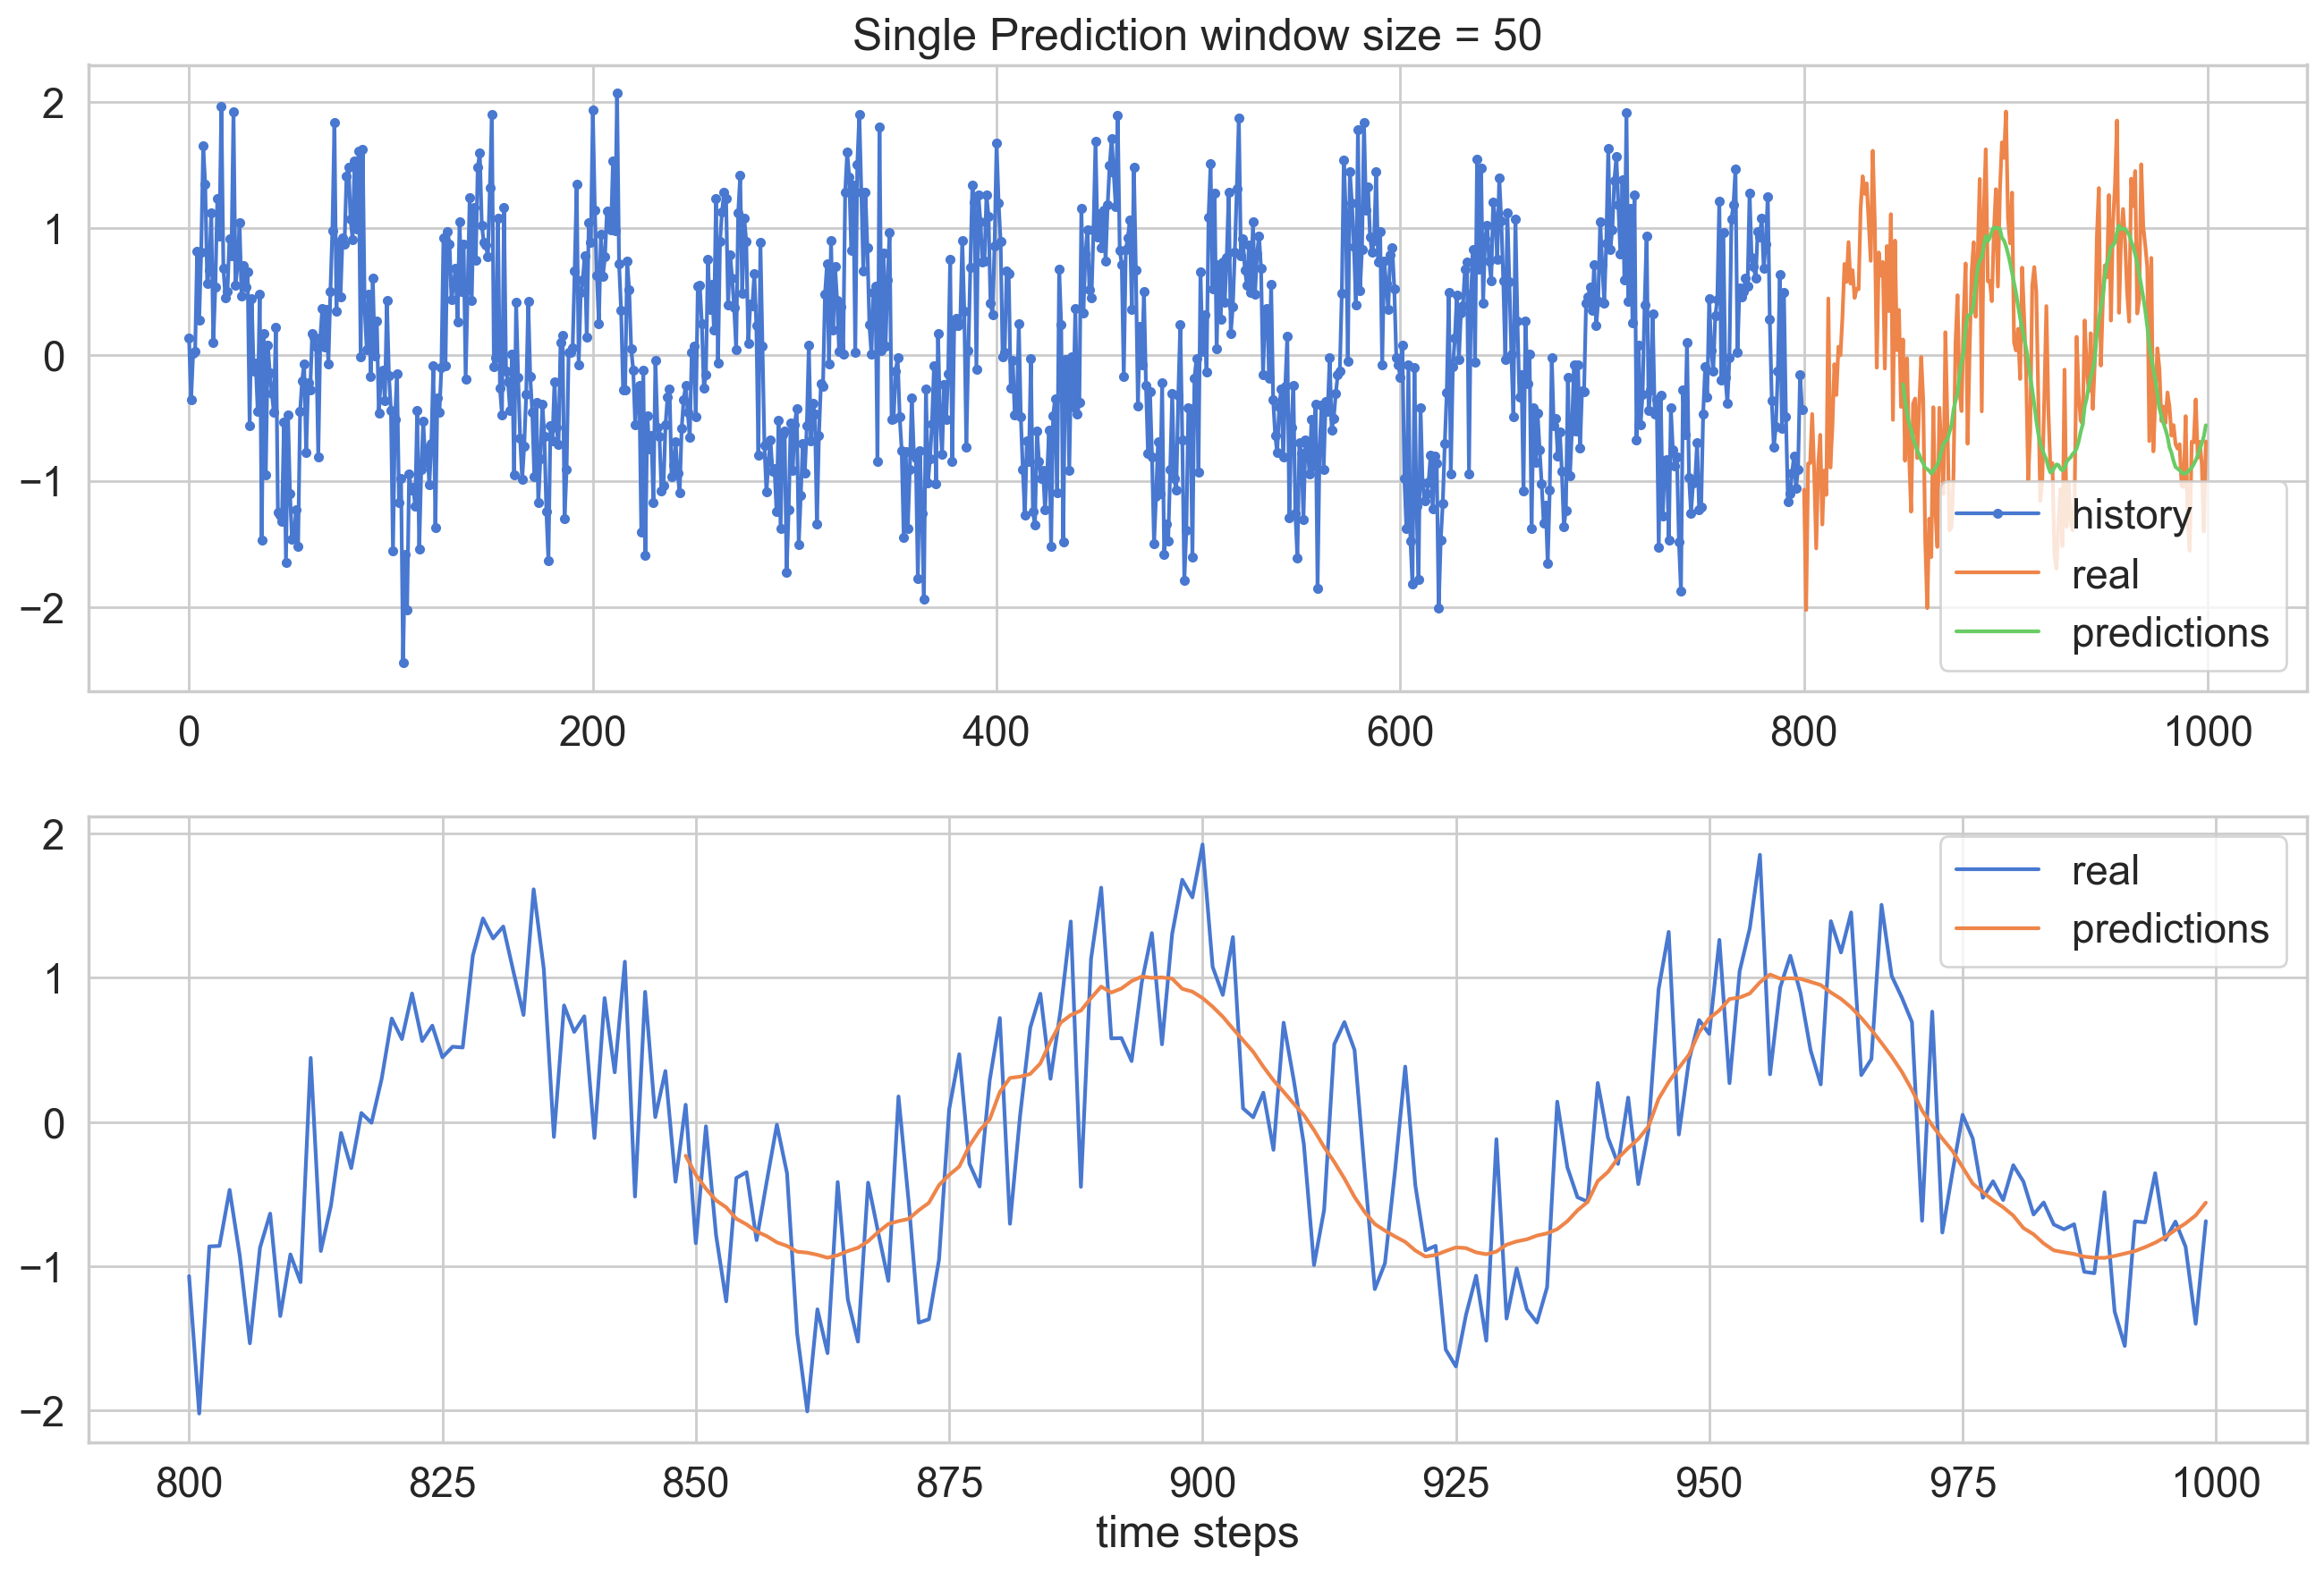

In [13]:
"""
Now that we have trained model, we will predict the X_test and plot it against y_test
We will plot the whole time series (both train and test set) plus the prediction for the test set.
To see better the predictions vs real vlaue, we will plot just the test set against the prediction
"""
open_predict_50 = open_model_50(X_test)
test_performance['open_model_50'] = open_model_50.evaluate(X_test, y_test, verbose = 0, return_dict = True)

open_plot(train.sine, test.sine, open_predict_50, window_size = 50, title = 'Single Prediction window size = 50')

Great! With some context, the model does a great job at capturing the general pattern. We can see the sine wave clearly!

### 3.1.3. label_width = 40, shift = 50

I want to see what happen if we predict further into the future!

Often, we know that it is not recommended to predict too far into the future. Like this, we predict 50 steps into the future! The first model we predicted next step into the future. The second model predicted 10 steps into the future. Now, let see what happen when we predict 50 steps into the future.

After splitting the data, there are 711 examples in the train set and 111 example in the test set.

Each input example has shape (40, 1) and corresponds to a real label of shape (1, 1). The model will be trained to take in the input of length 40 and predict the value of 50 steps into the future:

![](images/window_90.png)

Image credit: [Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


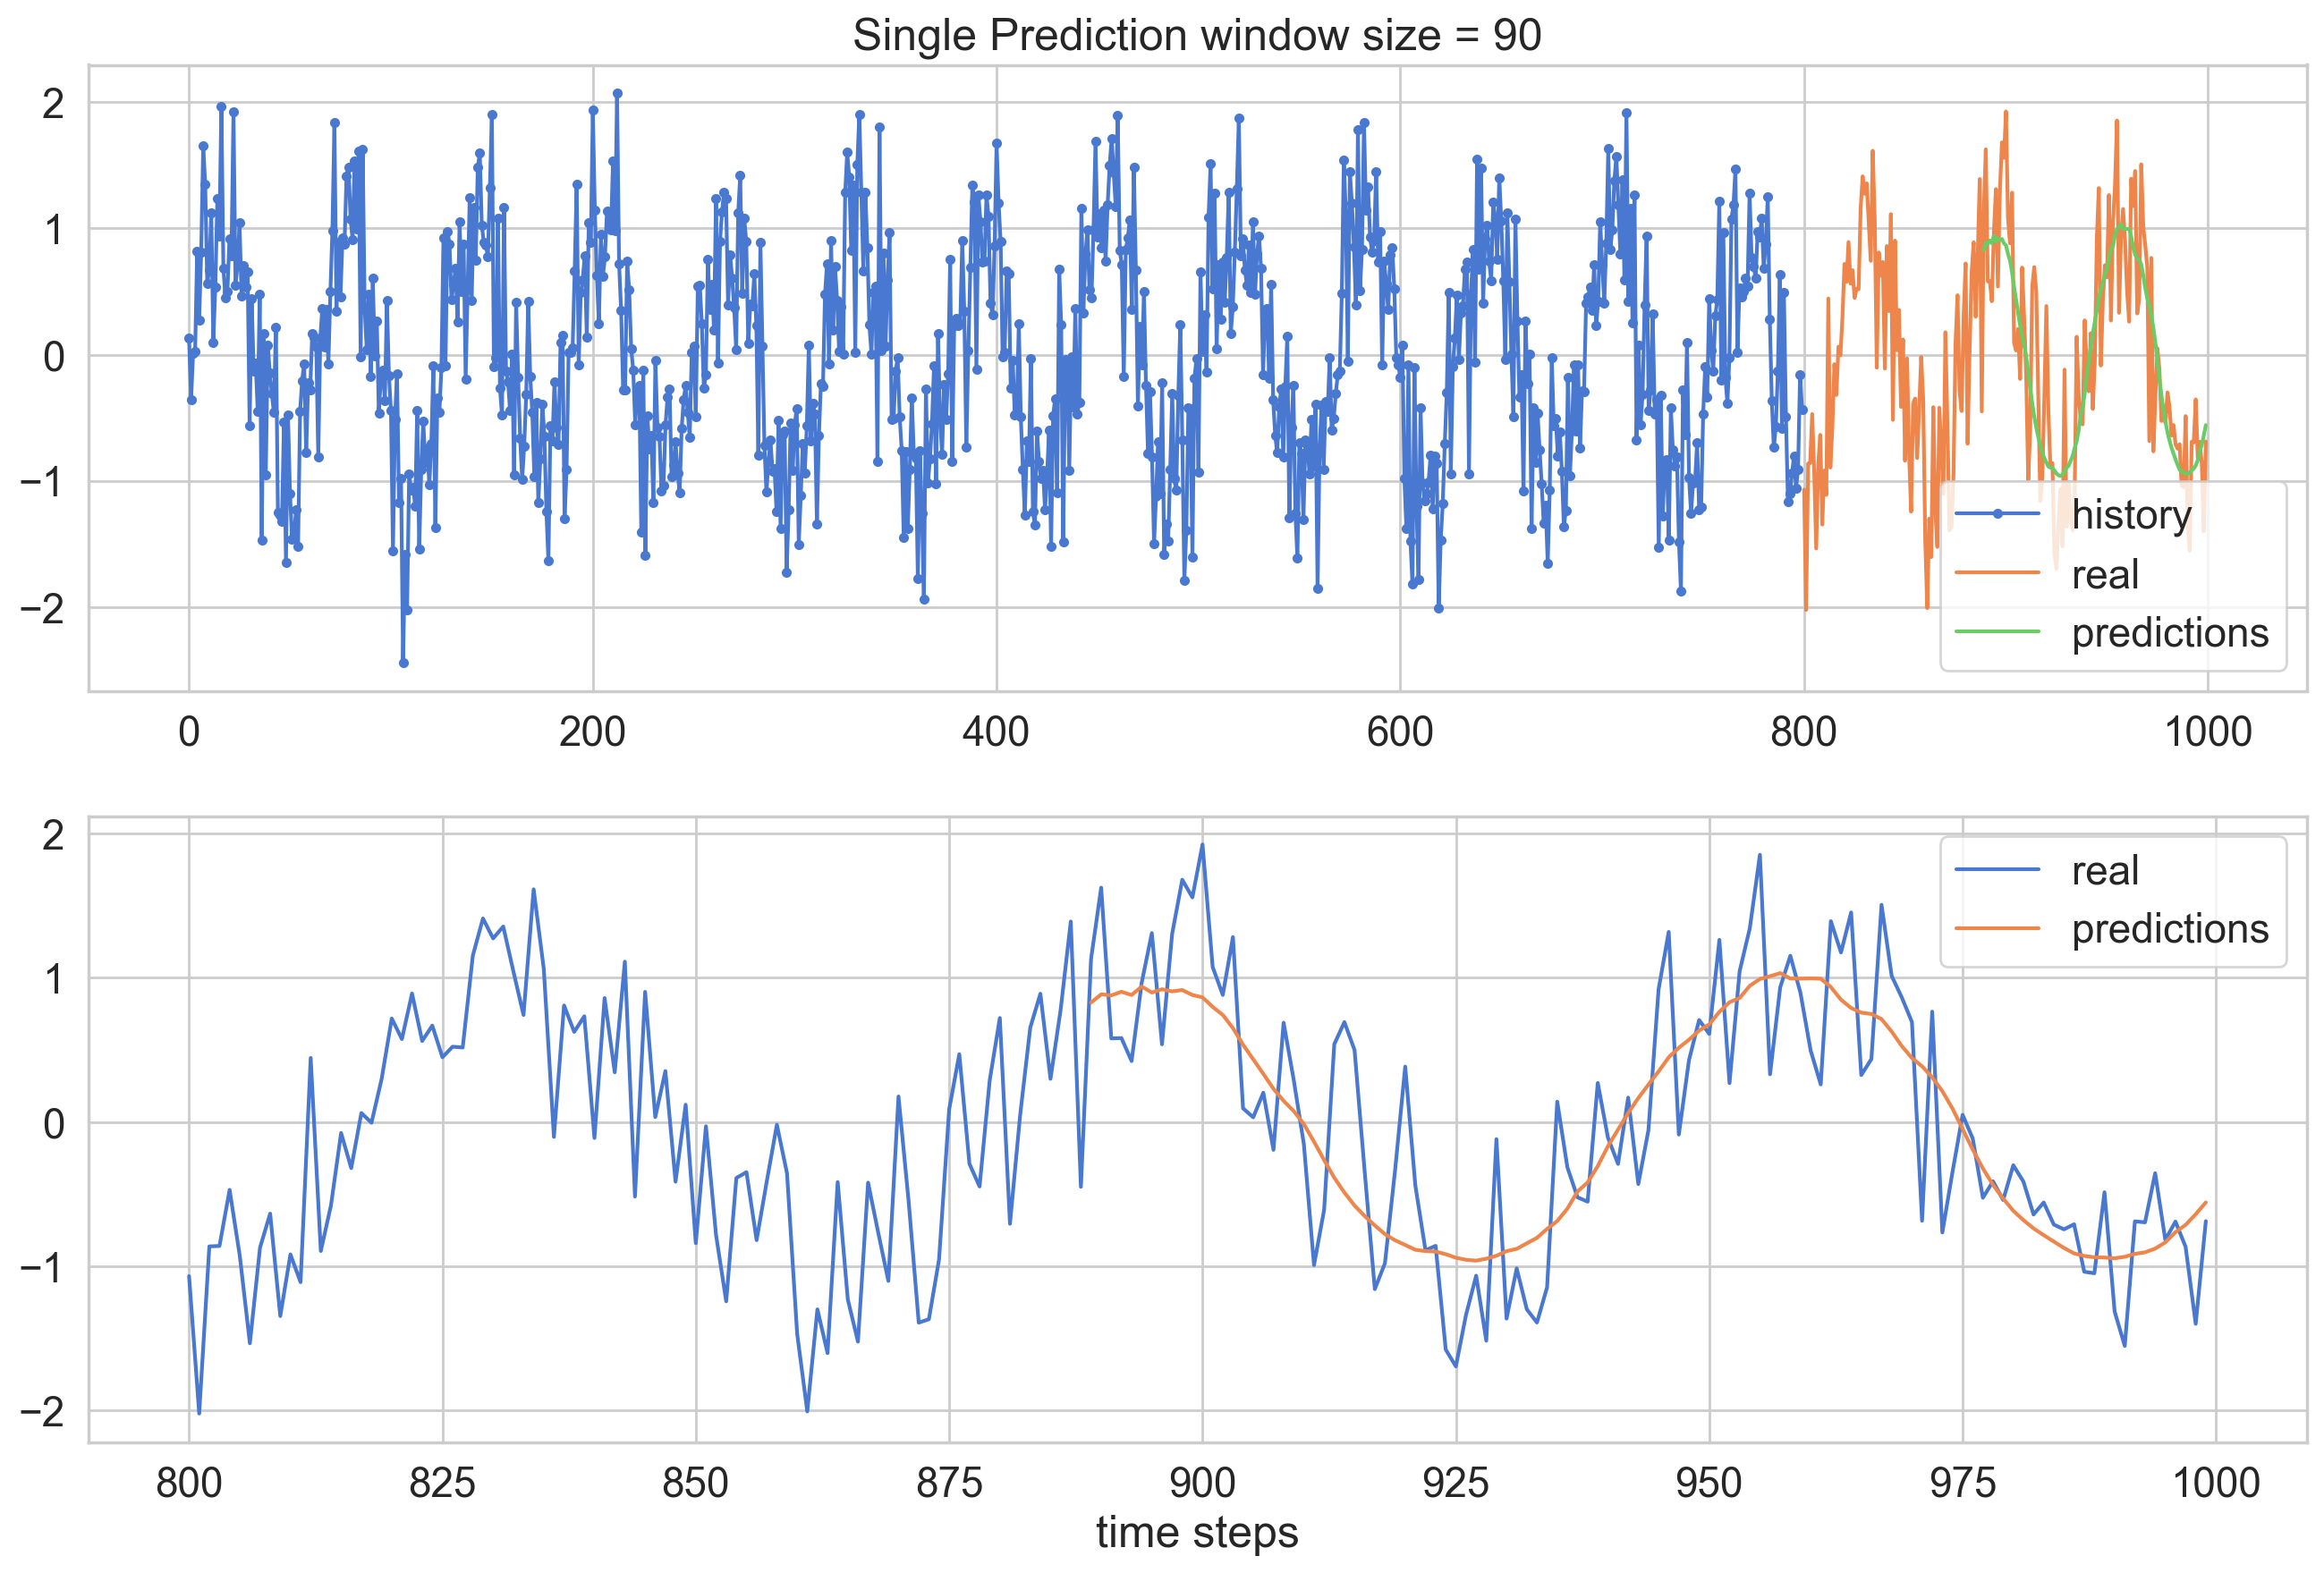

In [14]:
"""
Retrieve the parameters and create train and test sets
"""
single_params = window_params['single_output'][2]
X_train, y_train, X_test, y_test = get_datasets(train, test, single_params)
print(f'single_params: {single_params}')

"""
Training the data on single prediction window size of 90.
Note that I renamed the open_model to open_model_90 to distinguish the two model. 90 implies window size.
All the hyperparameters are same for comparision purposes.
"""
data = (X_train, y_train)
open_model_90 = OpenModel(32)
history_open_90 = compile_and_fit(open_model_90, data, params)
IPython.display.clear_output()


"""
Now that we have trained model, we will predict the X_test and plot it against y_test
We will plot the whole time series (both train and test set) plus the prediction for the test set.
To see better the predictions vs real vlaue, we will plot just the test set against the prediction
"""
open_predict_90 = open_model_90.predict(X_test)
test_performance['open_model_90'] = open_model_90.evaluate(X_test, y_test, verbose = 0, return_dict = True)

open_plot(train.sine, test.sine, open_predict_90, window_size = 90, title = 'Single Prediction window size = 90')

It is so exciting to see that the model still does a great job at capturing the overall pattern of the data even though we predict 50 time-step into the future.

### 3.1.4. Performance of Single Prediction Models

The plots indicate that all models are learning effectively during training, as the predictions appear to follow the underlying pattern in the dataset.

We observe that when given a warm-up period, the predictions in the second and third models are less oscillatory compared to those in the first model.

A surprising result is that the third model performs well even when predicting 50 time steps into the future.

These observations are based on visual inspection of the plots. When examining the performance metrics, specifically the Mean Absolute Error (MAE), we find that the second and third models perform slightly better than the first. However, the improvement is not significant.

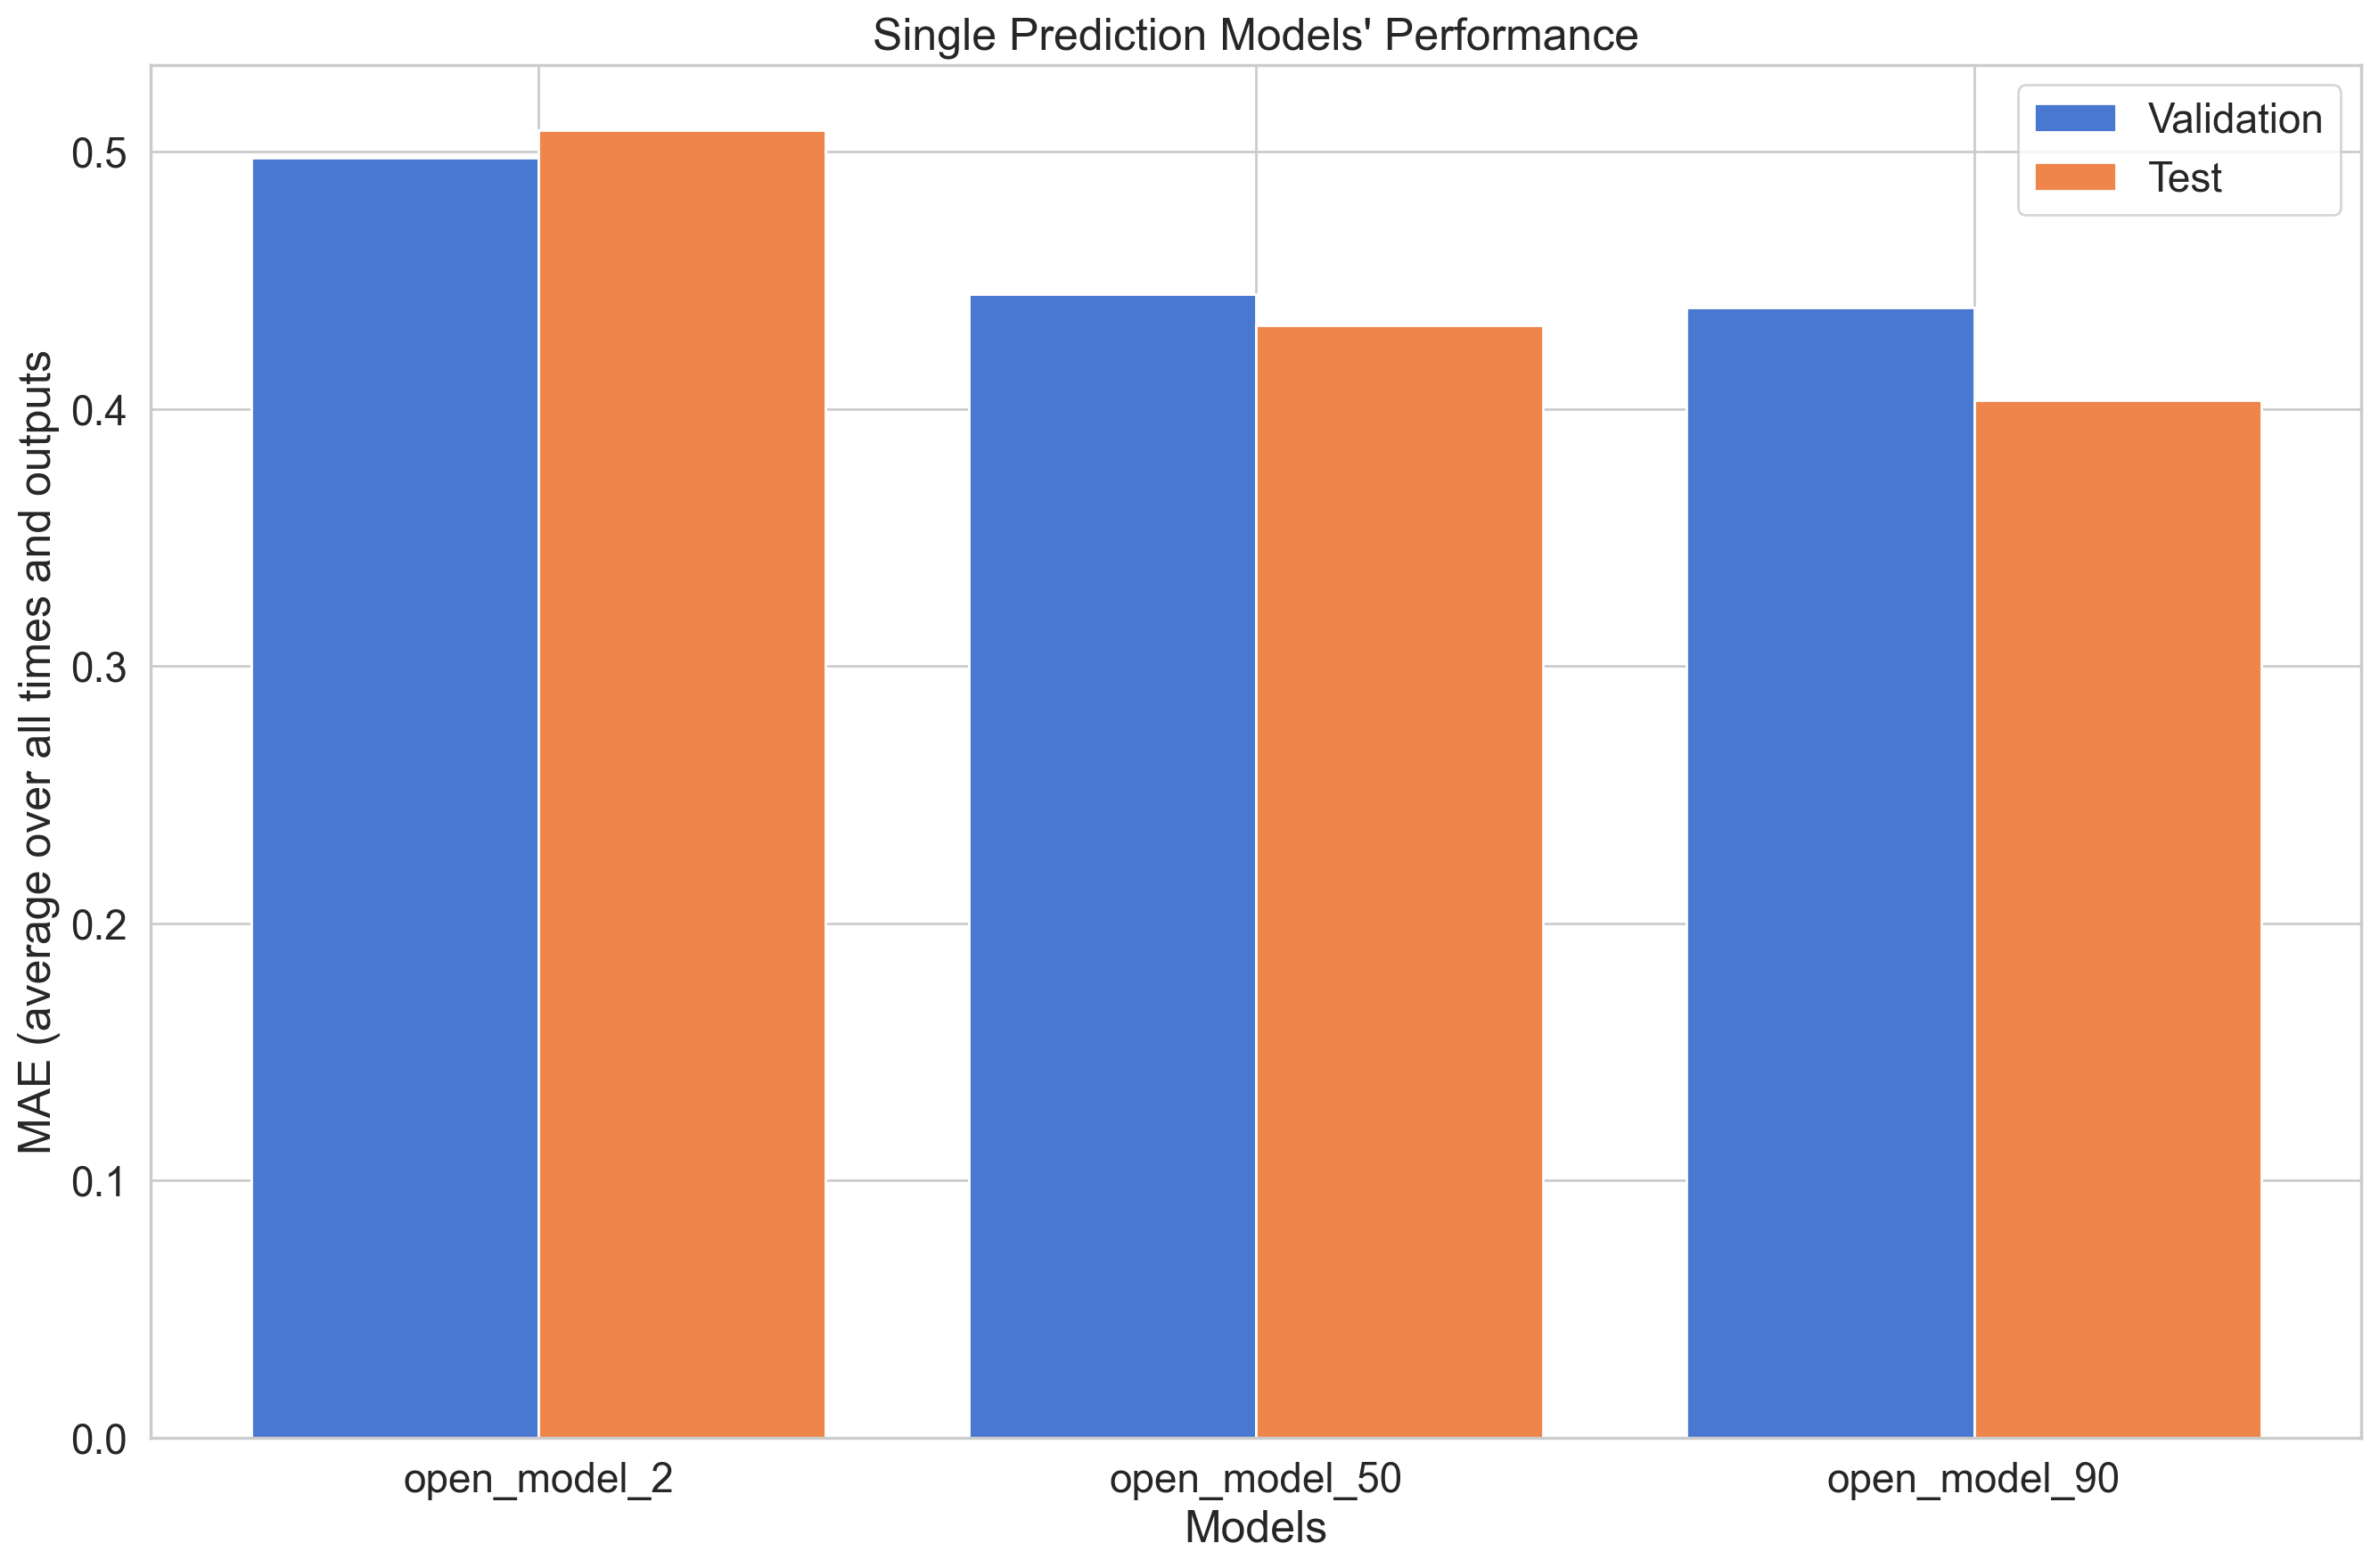

In [15]:
"""
record the performance for later use. For each model, we record 2 metrics: val loss and val mean absolute error
"""
window_size = [2, 50, 90]
model_names = [f'open_model_{i}' for i in window_size]

val_performance[f'open_model_{window_size[0]}']= (np.mean(history_open_2.history['val_loss']), np.mean(history_open_2.history['val_mean_absolute_error']))
val_performance[f'open_model_{window_size[1]}']= (np.mean(history_open_50.history['val_loss']), np.mean(history_open_50.history['val_mean_absolute_error']))
val_performance[f'open_model_{window_size[2]}']= (np.mean(history_open_90.history['val_loss']), np.mean(history_open_90.history['val_mean_absolute_error']))

val_losses, test_losses = [], []
val_maes, test_maes = [], []
for name in model_names:
    loss, mae = val_performance[name]
    val_losses.append(loss)
    val_maes.append(mae)
for name in model_names:
    d = test_performance[name]
    test_losses.append(d['loss'])
    test_maes.append(d['mean_absolute_error'])


idx = np.arange(len(model_names))
plt.bar(idx - 0.2, val_maes, 0.4, label = 'Validation')
plt.bar(idx + 0.2, test_maes, 0.4, label = 'Test')

plt.xticks(idx, model_names)
plt.xlabel('Models')
plt.ylabel('MAE (average over all times and outputs')
plt.title("Single Prediction Models' Performance")
plt.legend()
plt.show()

## 3.2 Multiple time step predictions using closed loop model.

### 3.2.1 input_width = 40, label_width = 40

In this model, the task is to predict the values from time step 41 to 80 given the 40 time-steps history.

After splitting the data, there are 721 examples in the train set and 121 example in the test set.

Each input example has shape (40, 1) and corresponds to a real label of shape (40, 1). The model will be trained to take in the inputs and predict the values of the next 40 time steps:


![](images/window_40_40.png)

Image credit: [Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)


In [16]:
"""

Recall: window_params = {'single_output': ((1, 1, 1), (40, 1, 1), (40, 1, 50)), 'multi-output': ((40, 40, 40), (40 , 120, 120)) }
        lr, MAX_EPOCHS = 0.001, 100
        params = (lr, MAX_EPOCHS)
"""

multi_params = window_params['multi-output'][0]
X_train, y_train, X_test, y_test = get_datasets(train, test, multi_params)
print(f'multi_params: {multi_params}')

Shape of train data: ((721, 40, 1), (721, 40, 1))
Shape of test data: ((121, 40, 1), (121, 40, 1))
multi_params: (40, 40, 40)


In [17]:
data = (X_train, y_train)
UNITS, OUT_STEPS = 32, multi_params[1] # multi_params = (input_width, label_width, shift)

feedback_model_40_40 = FeedBack(units = UNITS, out_steps = OUT_STEPS)
history_model_40_40 = compile_and_fit(feedback_model_40_40, data, params)
IPython.display.clear_output()

In [18]:
closed_predict_40_40 = feedback_model_40_40(X_test)
test_performance['feedback_model_40_40'] = feedback_model_40_40.evaluate(X_test, y_test, verbose = 0, return_dict = True)

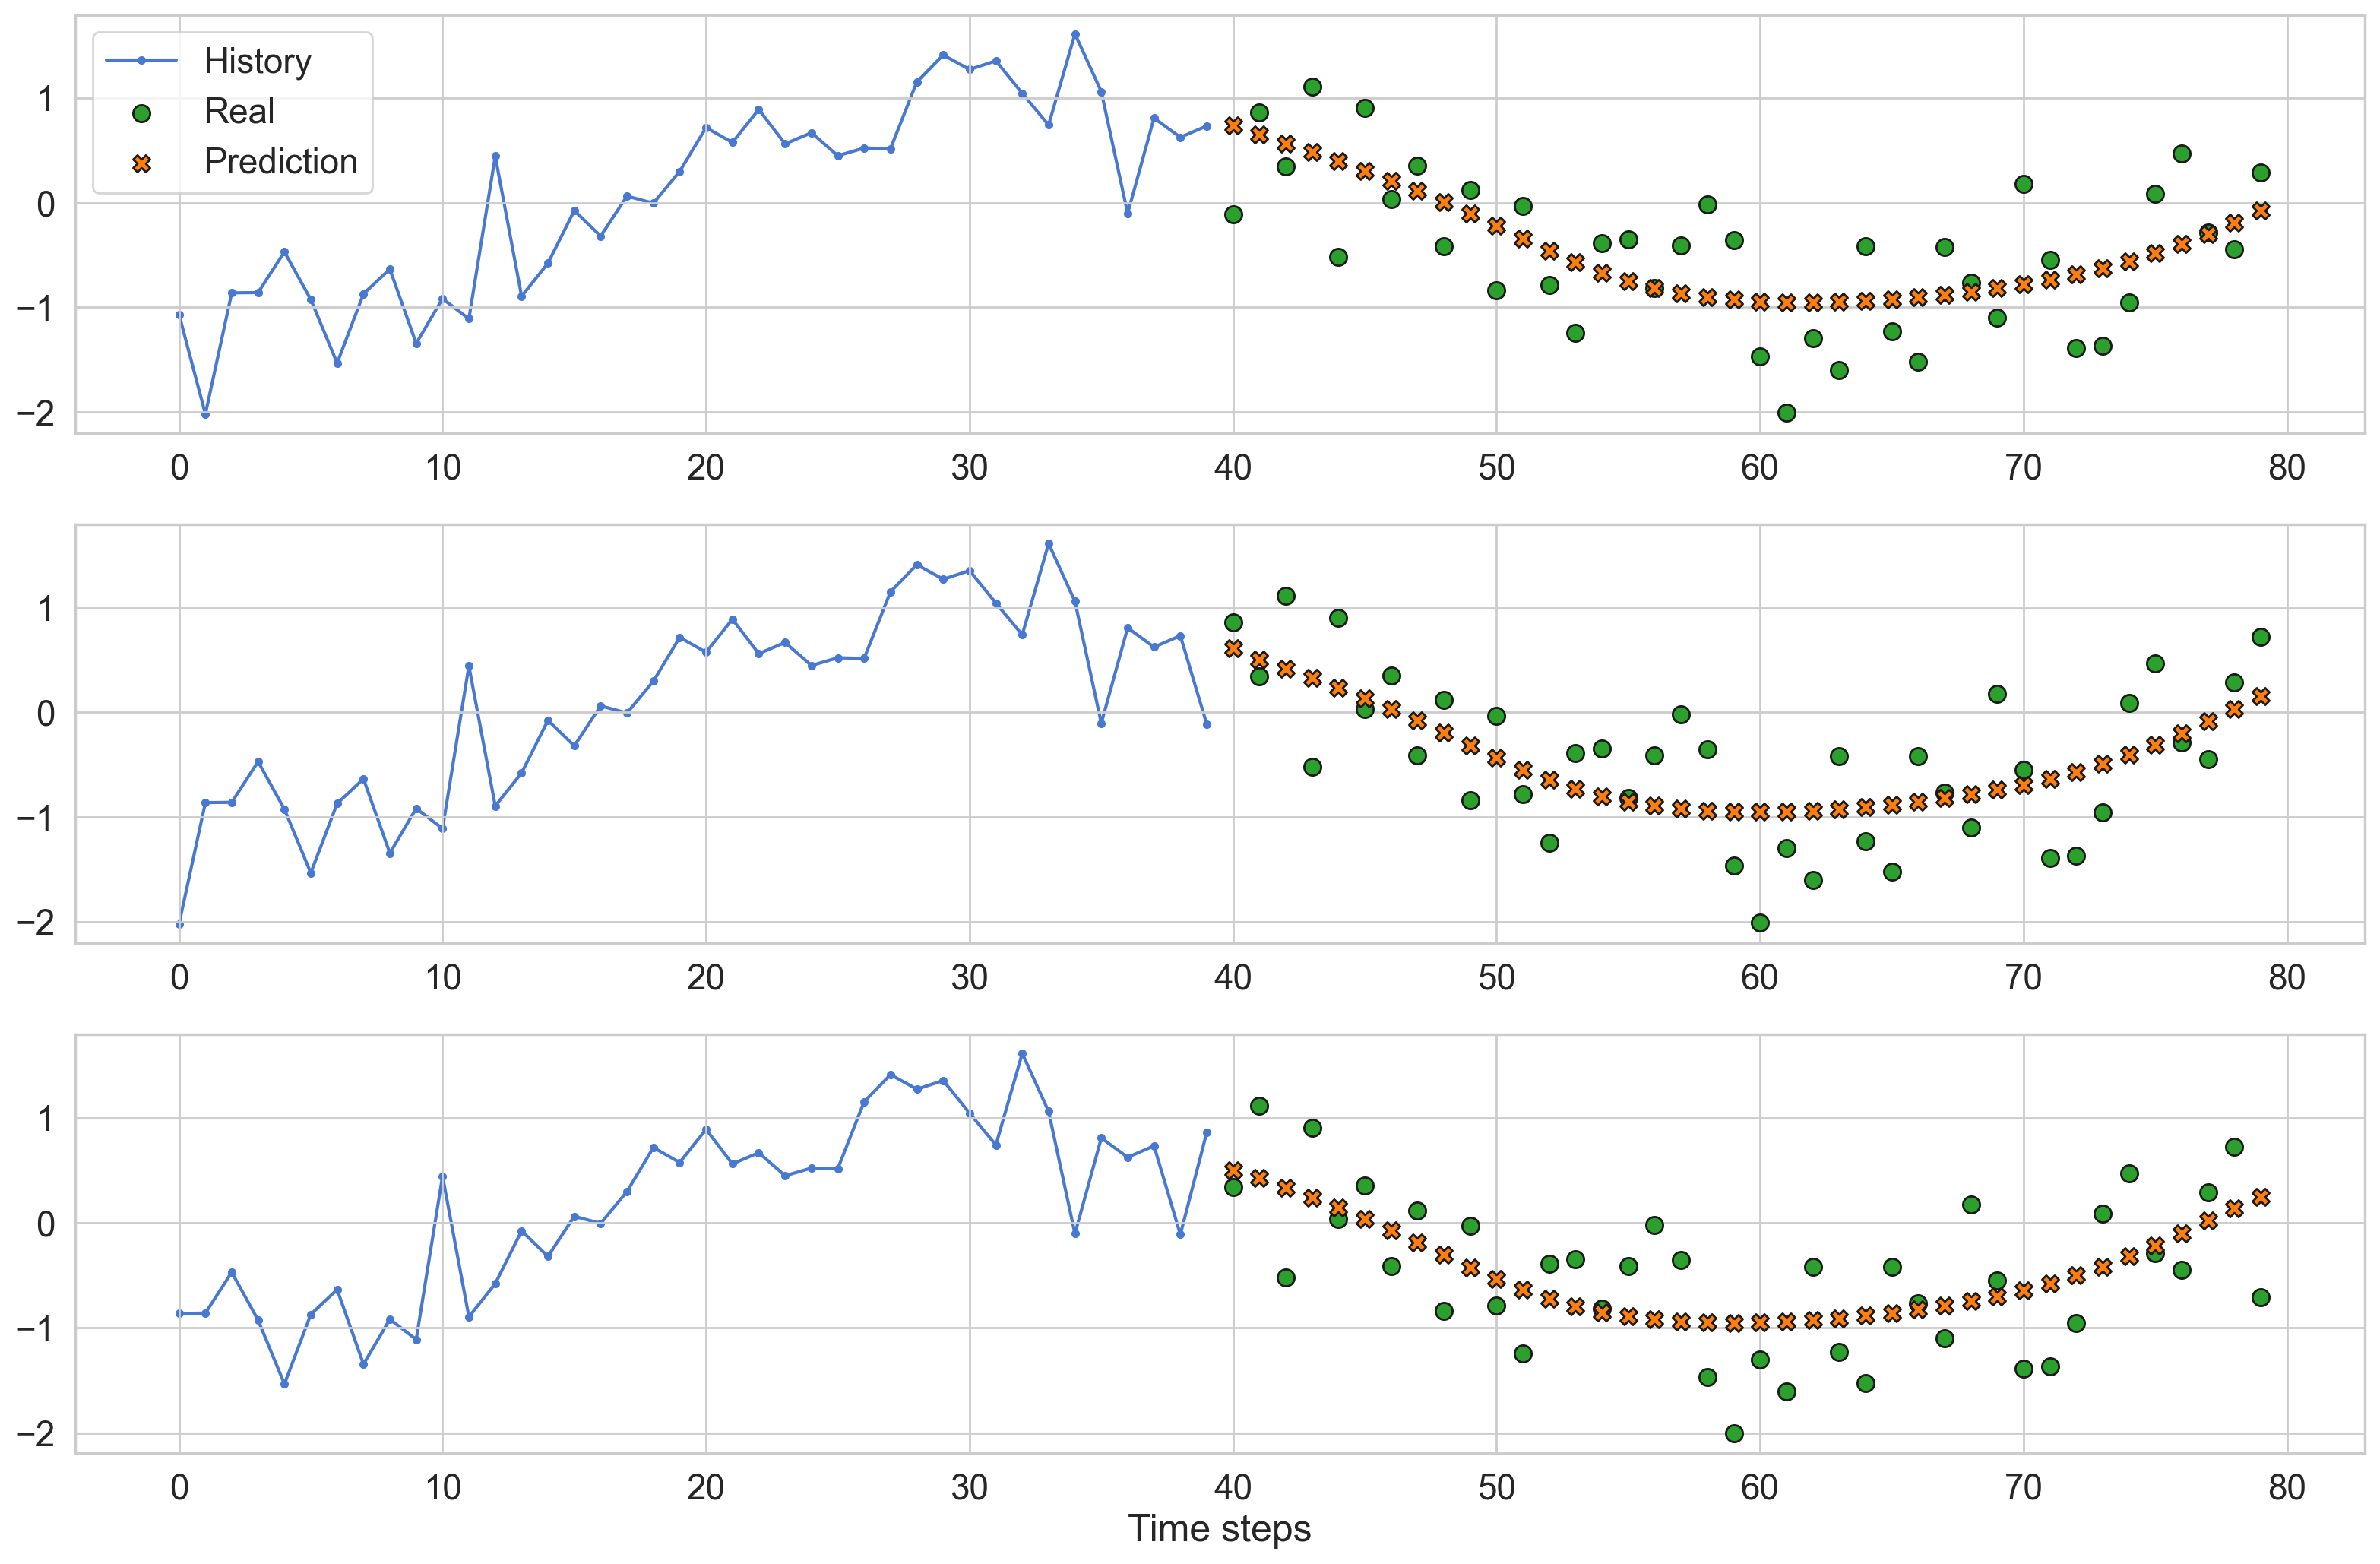

In [19]:
"""
define a plot function for autoregressive mode. It is slightly different to the open models.
We don't see the model performance on the scale of whole data. For autoregressive, we will look at
each example to see how well the model predict the new value.
"""

def closed_plot(hist, real, pred, window_size,  max_subplots = 3, zoom = False):
    input_width, label_width, shift = window_size
    hist_indices = [i for i in range(input_width)]
    label_indices = [i for i in range(input_width, input_width + label_width)]
    
    for n in range(max_subplots):
        plt.subplot(max_subplots, 1, n+1)
        if not zoom:
            plt.plot(hist_indices, hist[n, :, 0], label = 'History', marker = '.', zorder = -10)
        plt.scatter(label_indices, real[n, :, 0], label = 'Real', edgecolors = 'k', c = '#2ca02c', s= 64)
        plt.scatter(label_indices, pred[n, :, 0], label = 'Prediction', marker = 'X', edgecolors = 'k',
                   c = '#ff7f0e', s = 64)
        if n == 0:
            plt.legend( loc='upper left')
            plt.tight_layout()
    plt.xlabel('Time steps')
    plt.show()
closed_plot(X_test, y_test, closed_predict_40_40, multi_params, 3)
# closed_plot(X_test, y_test, closed_predict_40, multi_params, 3, zoom = True)


Although the prediction length is only 40 timesteps, the forecasts still form a curve that mirrors the underlying pattern of the real labels. In other words, the feedback model has effectively learned and captured the general pattern of the data.



### 3.2.2. input_width = 40, label_width = 120

When working with time series data, expanding the prediction horizon can provide valuable insights into the model's capabilities. In this experiment, we use a history of 40 timesteps to predict 120 timesteps into the future. While long-term forecasting can be challenging and is often not recommended due to increasing uncertainty, our goal is to evaluate the model's performance in predicting future values over an extended period.

We split our dataset into training and testing sets to assess the model's generalization ability. After preprocessing, we have:

- Training Set: 641 examples
- Test Set: 41 examples
- 
Each example in our dataset has the following shapes:

Input Example: (40, 1)
Real Label: (120, 1)

![](images/window_40_120.png) 

Image credit: [Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)


In [20]:
multi_params = window_params['multi-output'][1]
X_train, y_train, X_test, y_test = get_datasets(train, test, multi_params)
print(f'multi_params: {multi_params}')



Shape of train data: ((641, 40, 1), (641, 120, 1))
Shape of test data: ((41, 40, 1), (41, 120, 1))
multi_params: (40, 120, 120)


In [21]:
data = (X_train, y_train)
UNITS, OUT_STEPS = 32, multi_params[1] # multi_params = (input_width, label_width, shift)

feedback_model_40_120 = FeedBack(units = UNITS, out_steps = OUT_STEPS)
history_model_40_120 = compile_and_fit(feedback_model_40_120, data, params)

IPython.display.clear_output()


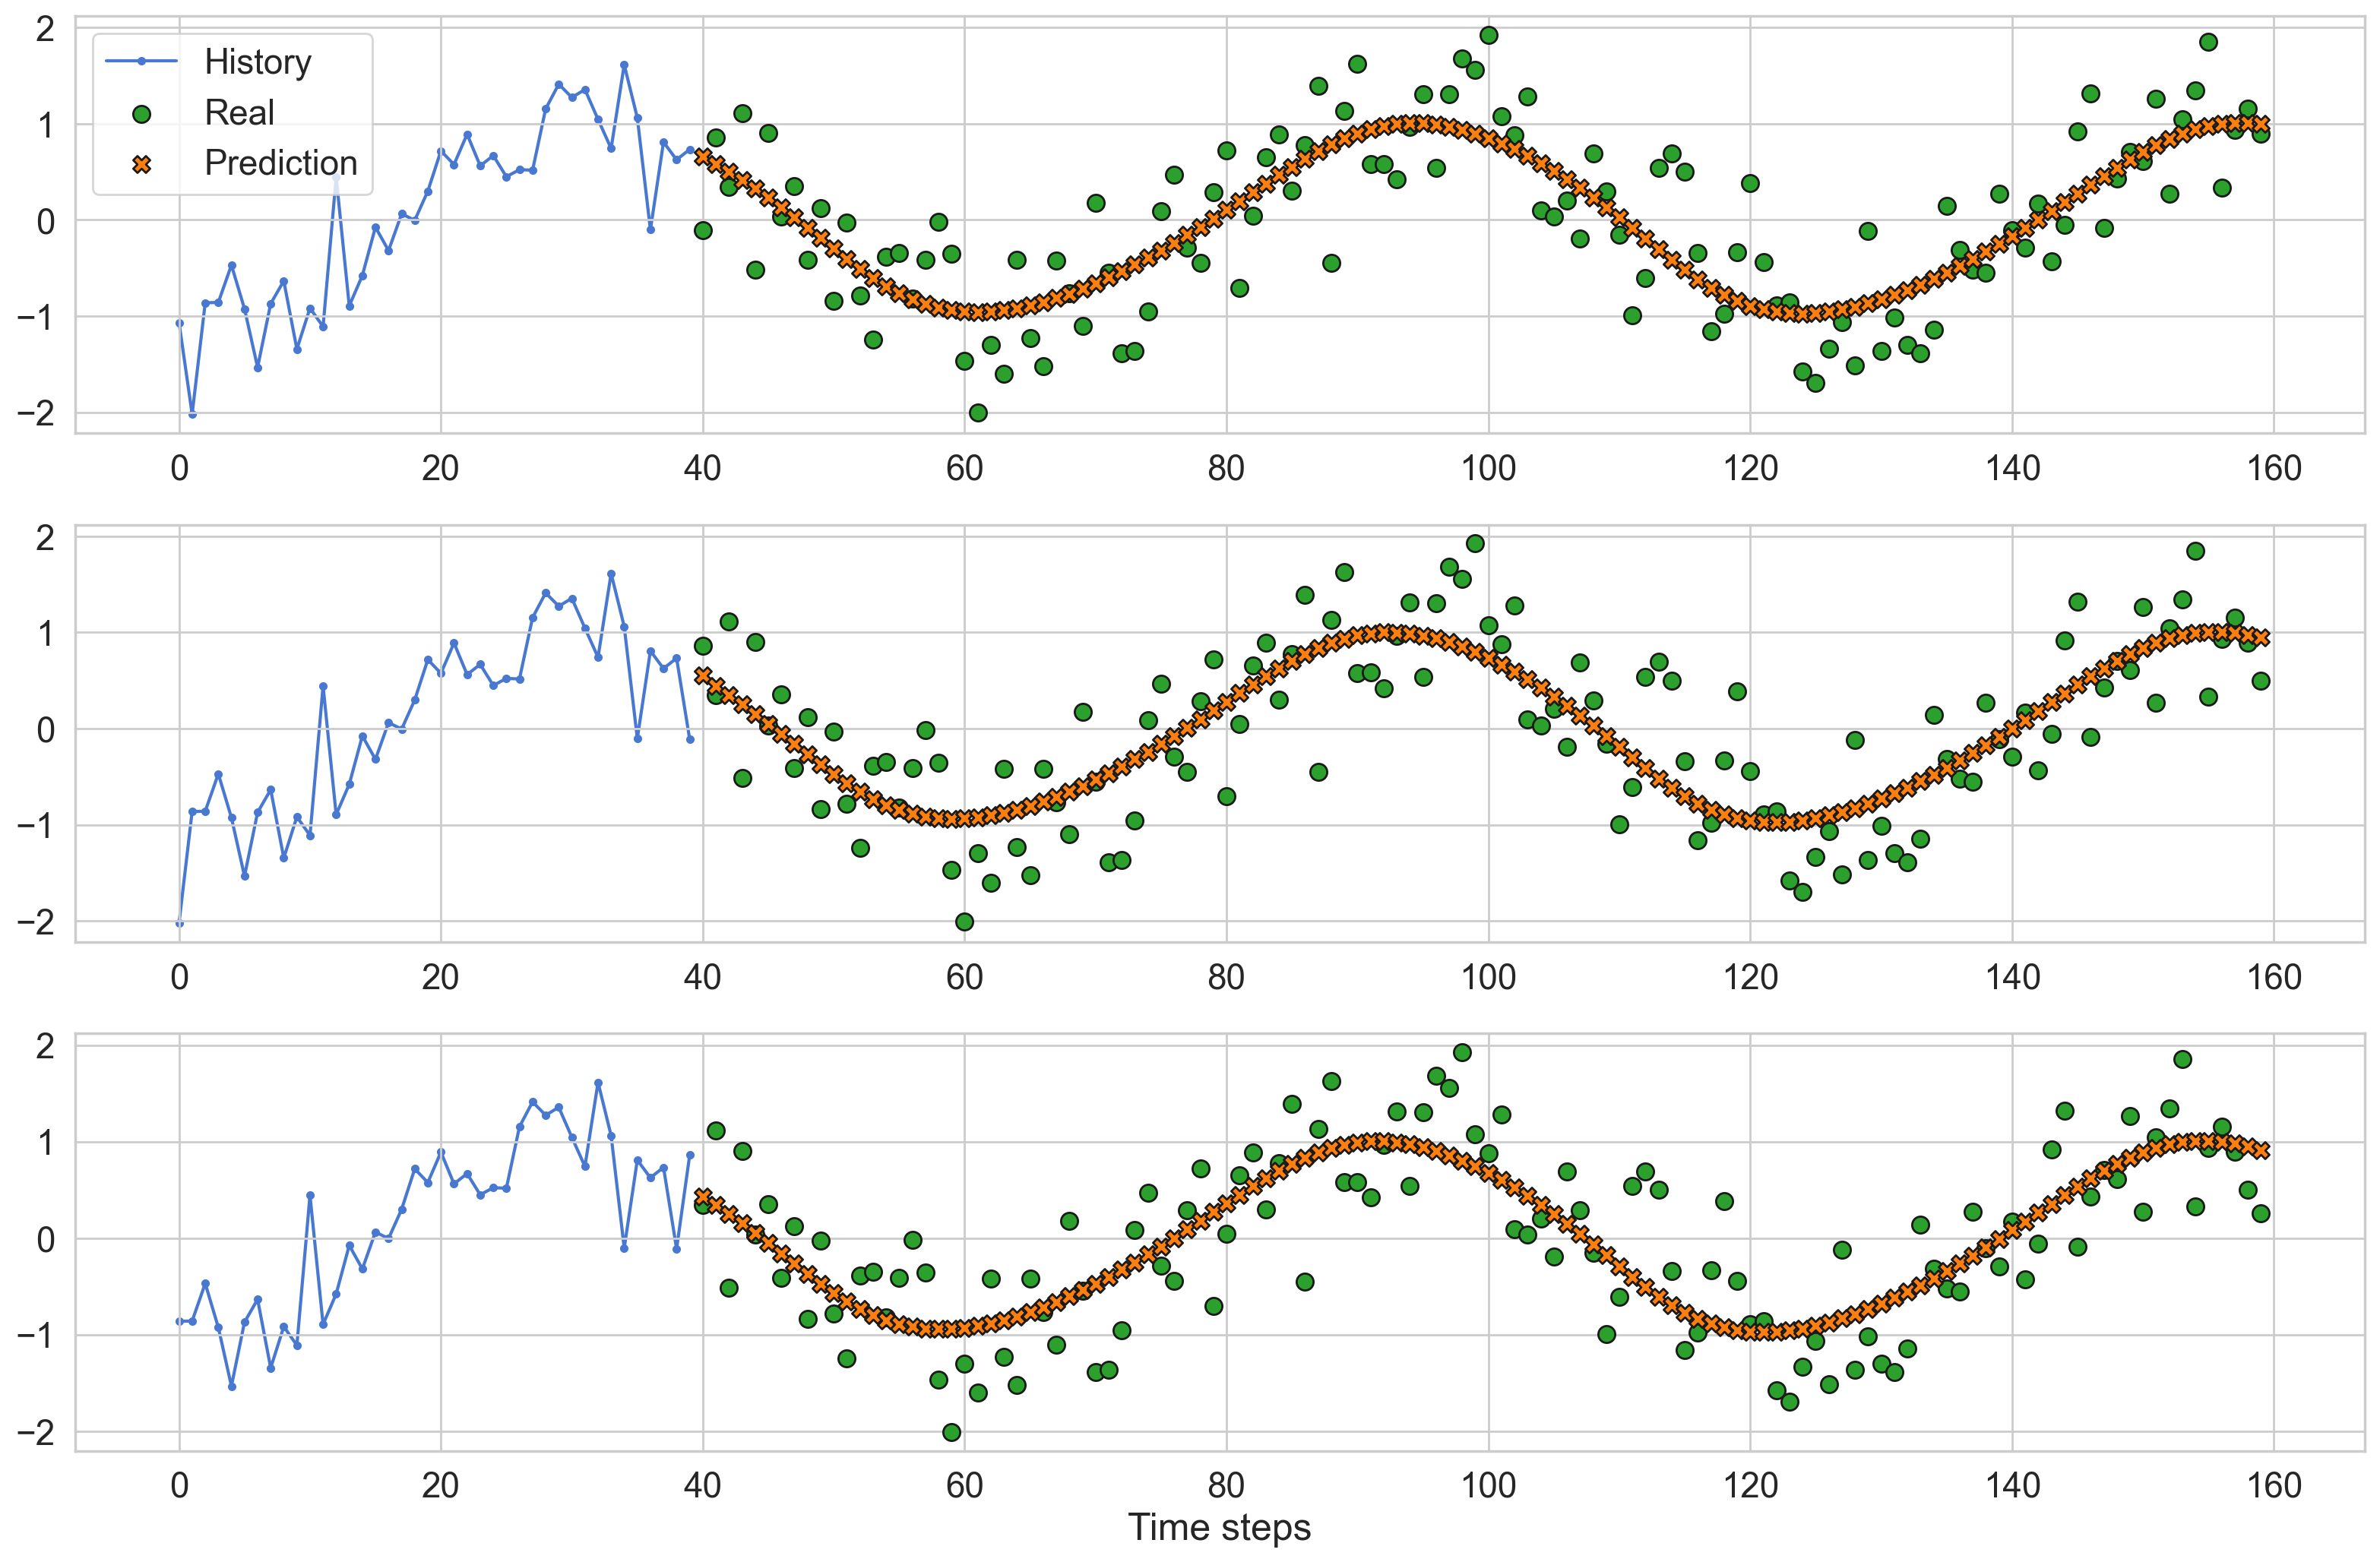

In [22]:
closed_predict_40_120 = feedback_model_40_120(X_test)
test_performance['feedback_model_40_120'] = feedback_model_40_120.evaluate(X_test, y_test, verbose = 0, return_dict = True)
closed_plot(X_test, y_test, closed_predict_40_120, multi_params, 3)

With longer prediction length, we can see a clear sine wave which indicates this model also do a great job at capturing the data's pattern.

## 3.3. All models' performance

Our findings reveal that open models, which incorporate real data during prediction, generally perform better than autoregressive approaches. This is not surprising, as open models benefit from the added context provided by real data. However, one of the open models, referred to as open_model_2, performed the worst among all the models. The lack of context during its prediction process likely contributed to its poor performance.

While open models show promise due to their lower error rates, feedback models offer a viable alternative when real data is not readily available. The slight increase in error is often outweighed by the convenience and feasibility of using feedback models in real-world applications.

In [23]:
feedback_model_names = ['feedback_model_40_40', 'feedback_model_40_120']

val_performance[feedback_model_names[0]]= (np.mean(history_model_40_40.history['val_loss']), np.mean(history_model_40_40.history['val_mean_absolute_error']))
val_performance[feedback_model_names[1]]= (np.mean(history_model_40_120.history['val_loss']), np.mean(history_model_40_120.history['val_mean_absolute_error']))

val_loss, test_loss = [], []
val_mae, test_mae = [], []
for name in feedback_model_names:
    loss, mae = val_performance[name]
    d = test_performance[name]
    val_loss.append(loss)
    val_mae.append(mae)
    test_loss.append(d['loss'])
    test_mae.append(d['mean_absolute_error'])
val_losses.extend(val_loss)
test_losses.extend(test_loss)
val_maes.extend(val_mae)
test_maes.extend(test_mae)
model_names.extend(feedback_model_names)

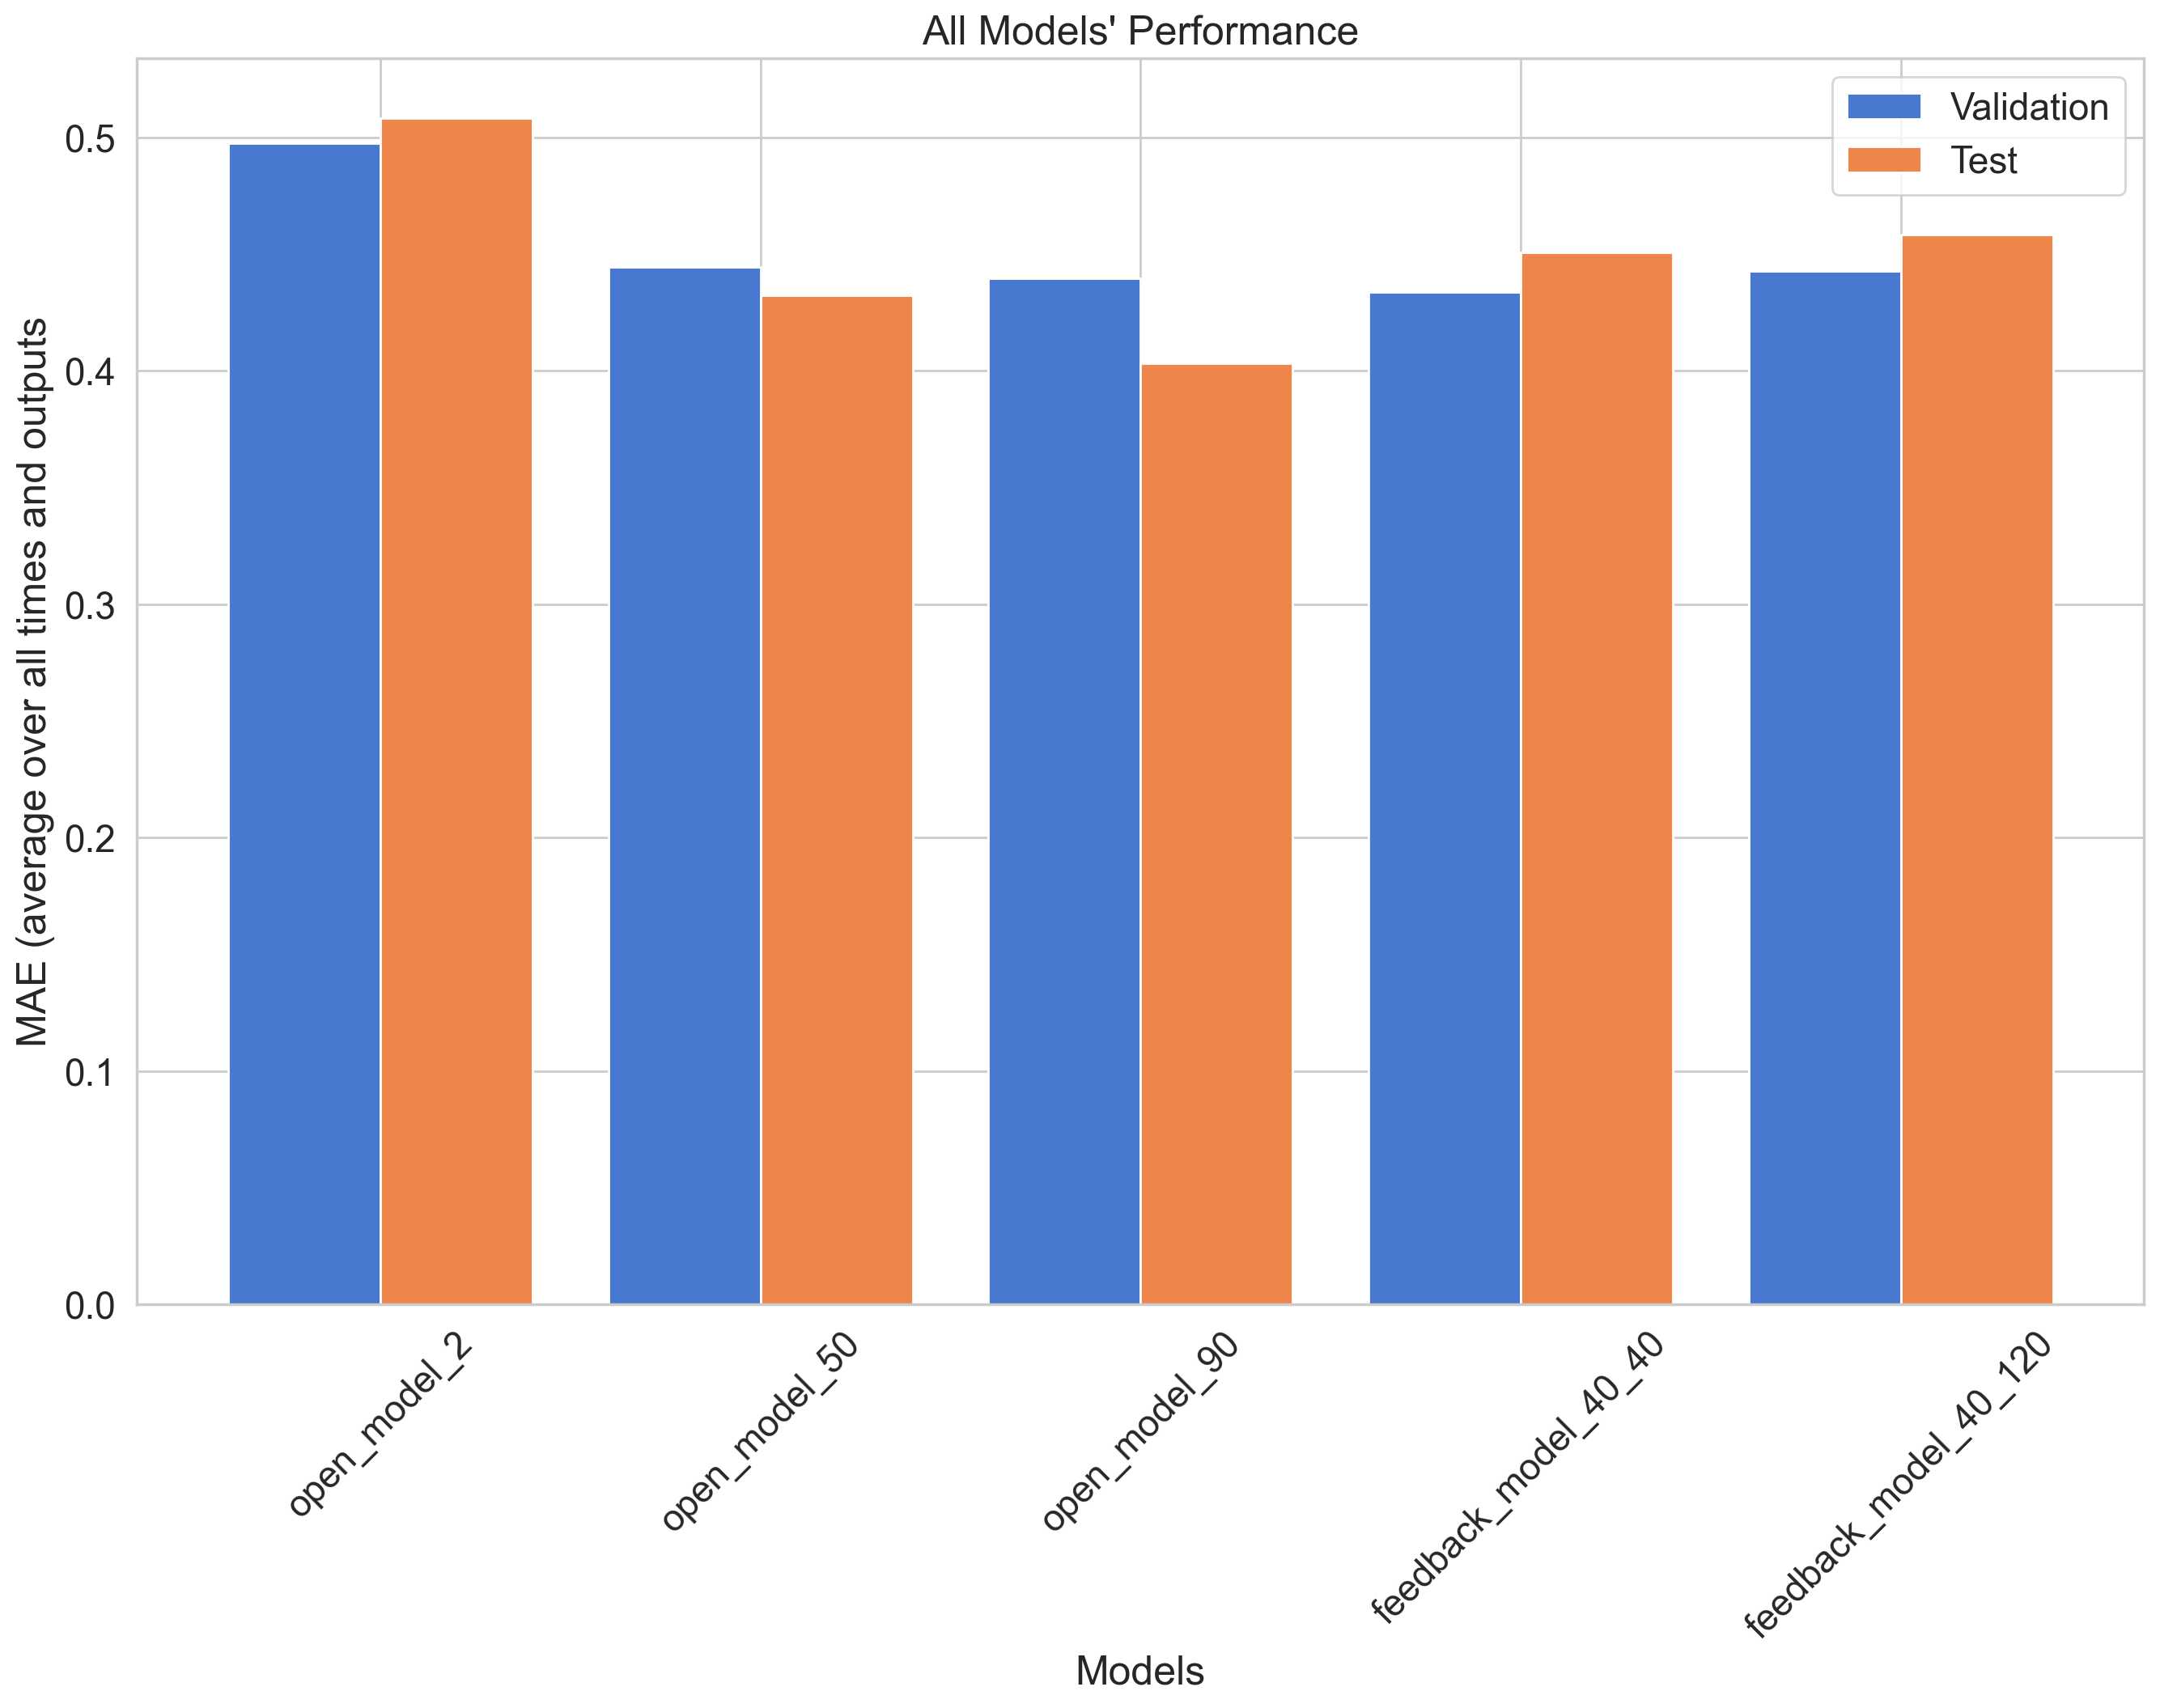

In [24]:
idx = np.arange(len(model_names))
plt.bar(idx - 0.2, val_maes, 0.4, label = 'Validation')
plt.bar(idx + 0.2, test_maes, 0.4, label = 'Test')

plt.xticks(ticks = idx, labels = model_names,
          rotation = 45)
plt.xlabel('Models')
plt.ylabel('MAE (average over all times and outputs')
plt.title("All Models' Performance")
plt.legend()
plt.show()

# 4. Extrapolation

Predicting future values without knowing their real counterparts is a true test of a model's learning capability. In this experiment, we aim to see if our models have effectively learned during training by examining their forecasting outputs.

**Forecasting Approach:** To evaluate the models, we expect the forecasts to exhibit a sine pattern, indicating that the models have captured the underlying data structure. We employ two different models for single and multiple predictions.

1. Single Prediction with open_model_90:

    We use open_model_90 to predict 50 timesteps into the future.
    The prediction from the last sequence in the test set (y_test) is utilized to forecast the next 40 timesteps. This model, in particular, still uses the real values to predict future values.
   
2. Multiple Predictions with feedback_model_40:

    We employ feedback_model_40 for forecasting 40 timesteps into the future.
    Unlike open_model_90, this model uses its own predictions iteratively to generate future values. Our goal is to check if feedback_model_40 can predict as accurately as open_model_90


## 4.1 open_model_90

In [25]:
single_params = window_params['single_output'][2]
print(single_params)
_, _ ,X_test, y_test = get_datasets(train, test, single_params)
print(y_test.shape)

(40, 1, 50)
Shape of train data: ((711, 40, 1), (711, 1, 1))
Shape of test data: ((111, 40, 1), (111, 1, 1))
(111, 1, 1)


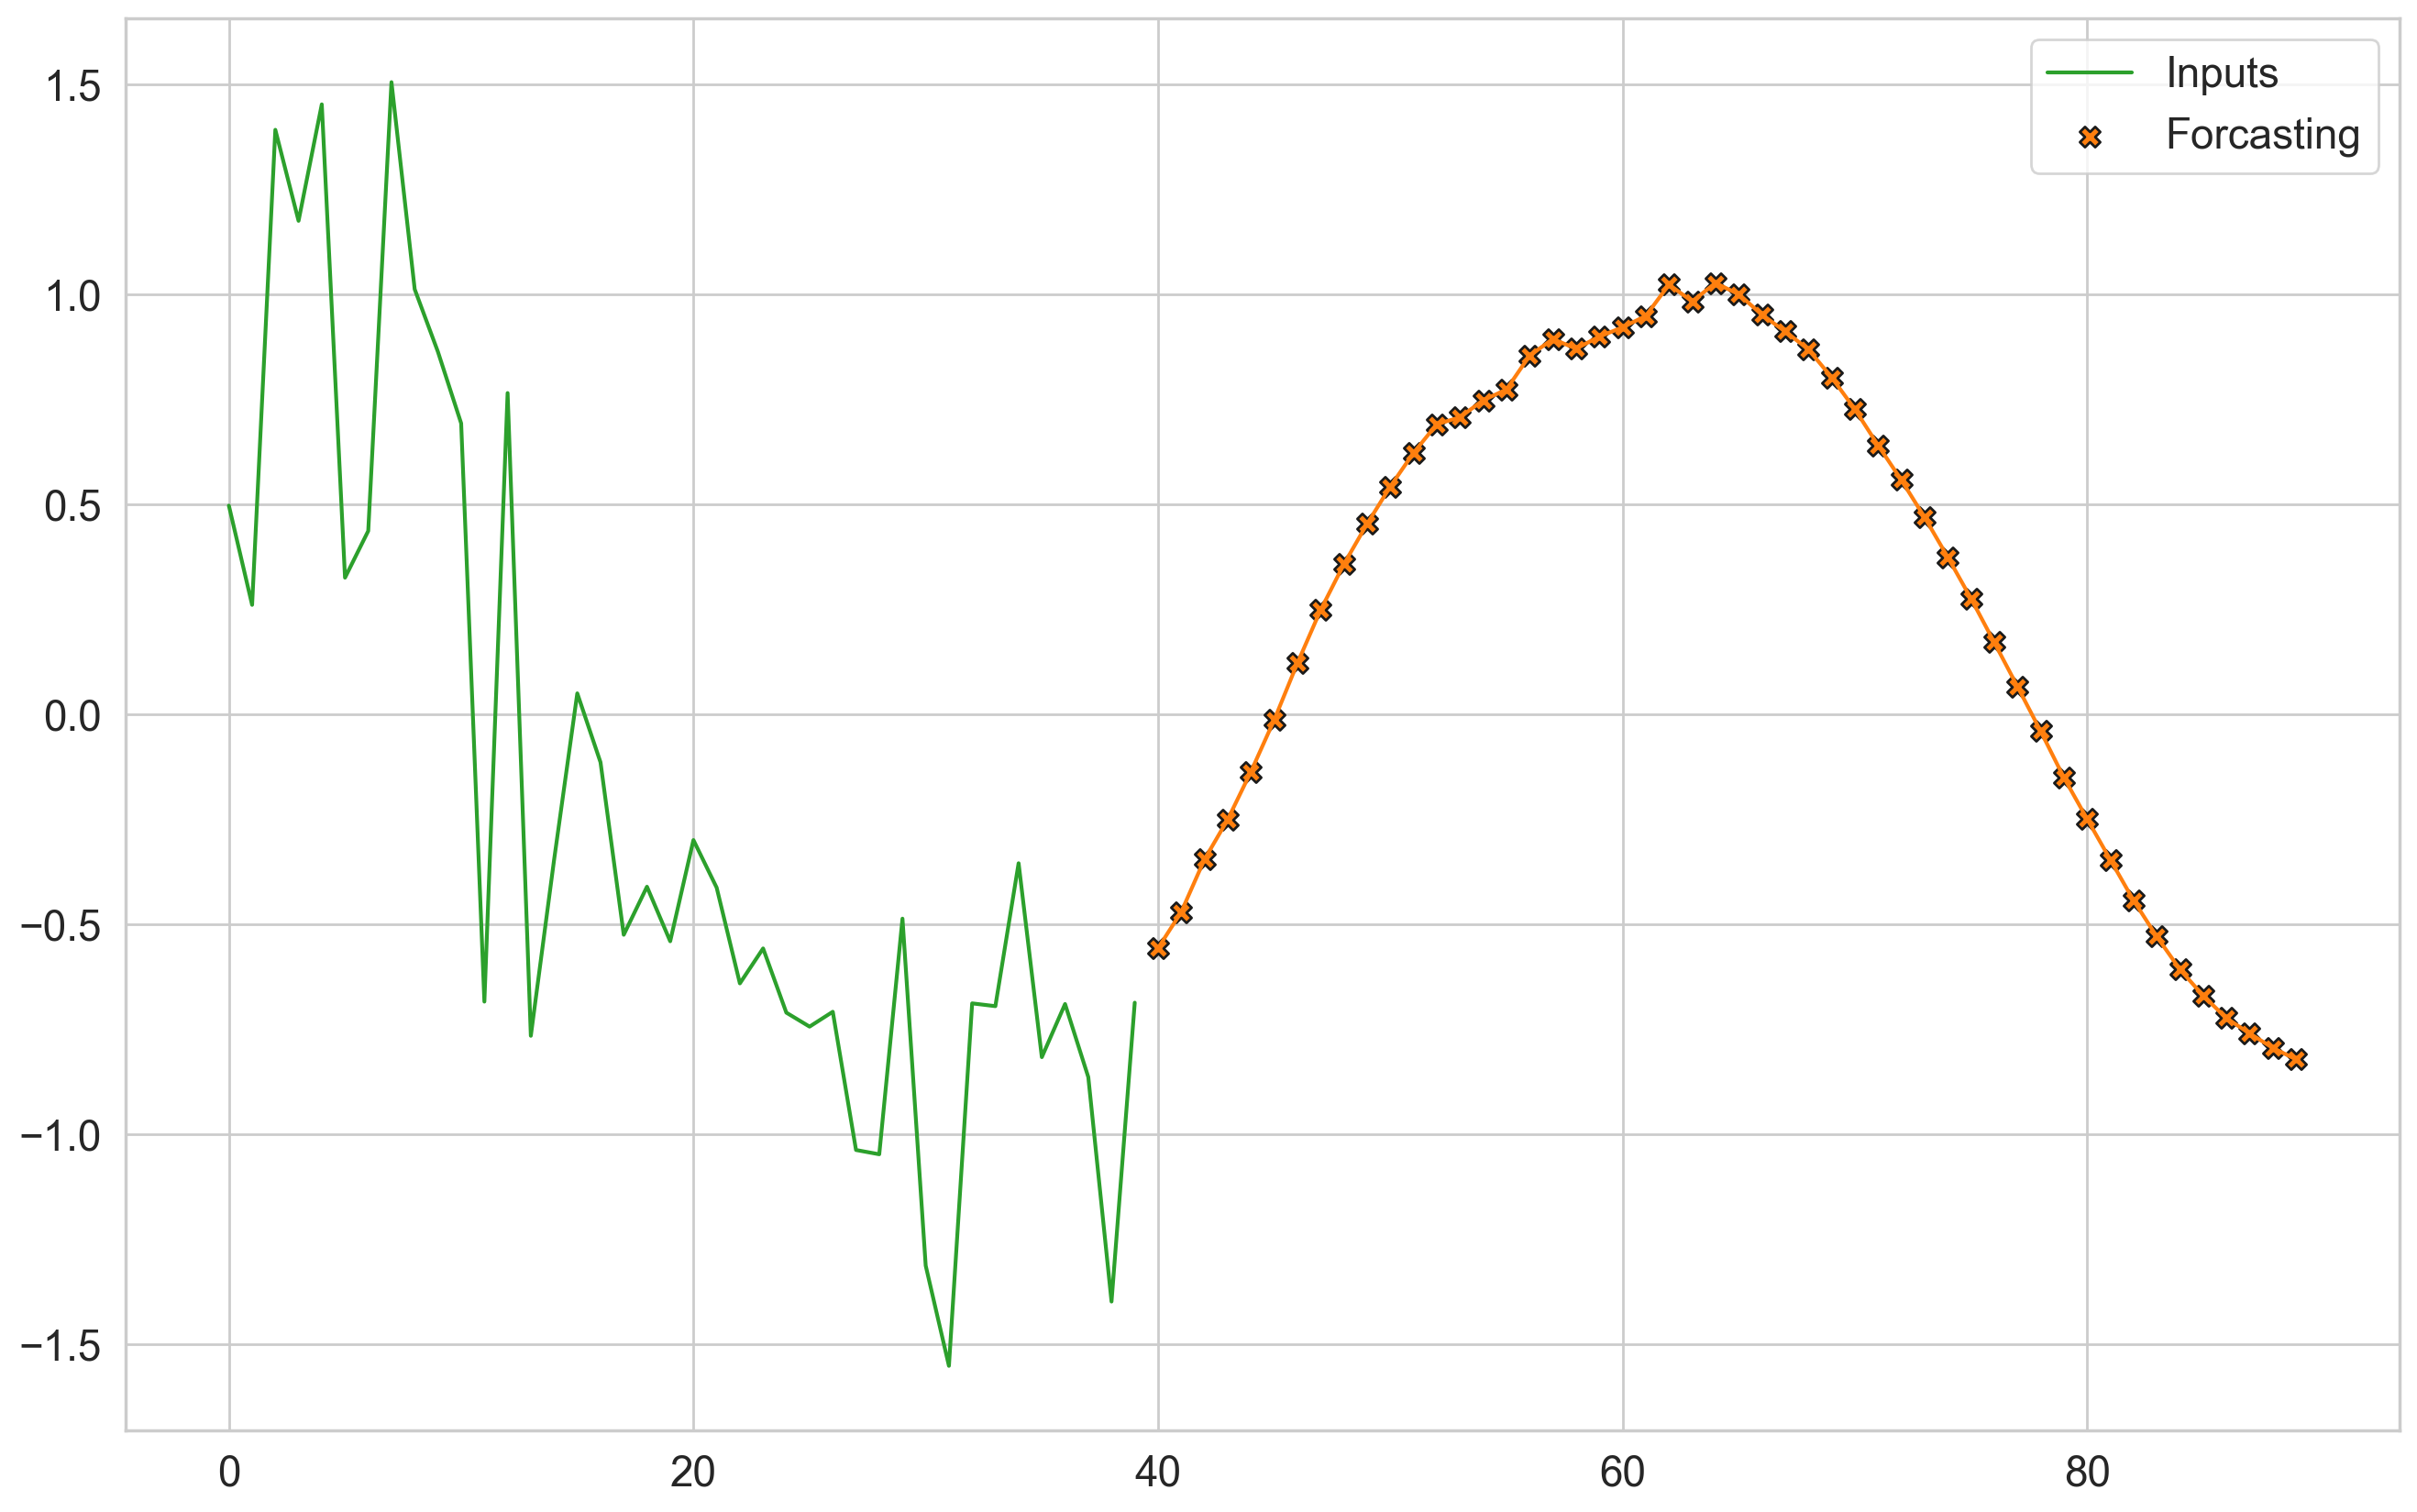

In [26]:
y = y_test[-90:]

"""
y is the last 90 time-step in the test set. We will use this to predict the next

"""
X_forcast = []
for i in range(0, 50):
    X_forcast.append(y[i:i+40, :, 0])
X_forcast = np.array(X_forcast)

forcasting = open_model_90(X_forcast)

plt.plot([i for i in range( 40)], y_test[-40:, :, 0], label = 'Inputs', c = '#2ca02c')
plt.plot([i for i in range(40, 40 +50)], forcasting,c = '#ff7f0e' )
plt.scatter([i for i in range(40, 40 +50)], forcasting, label = 'Forcasting', marker = 'X', edgecolors = 'k',
                   c = '#ff7f0e', s = 64)
plt.legend()
plt.show()


## 4.2 feedback_model_40_40

Shape of train data: ((721, 40, 1), (721, 40, 1))
Shape of test data: ((121, 40, 1), (121, 40, 1))


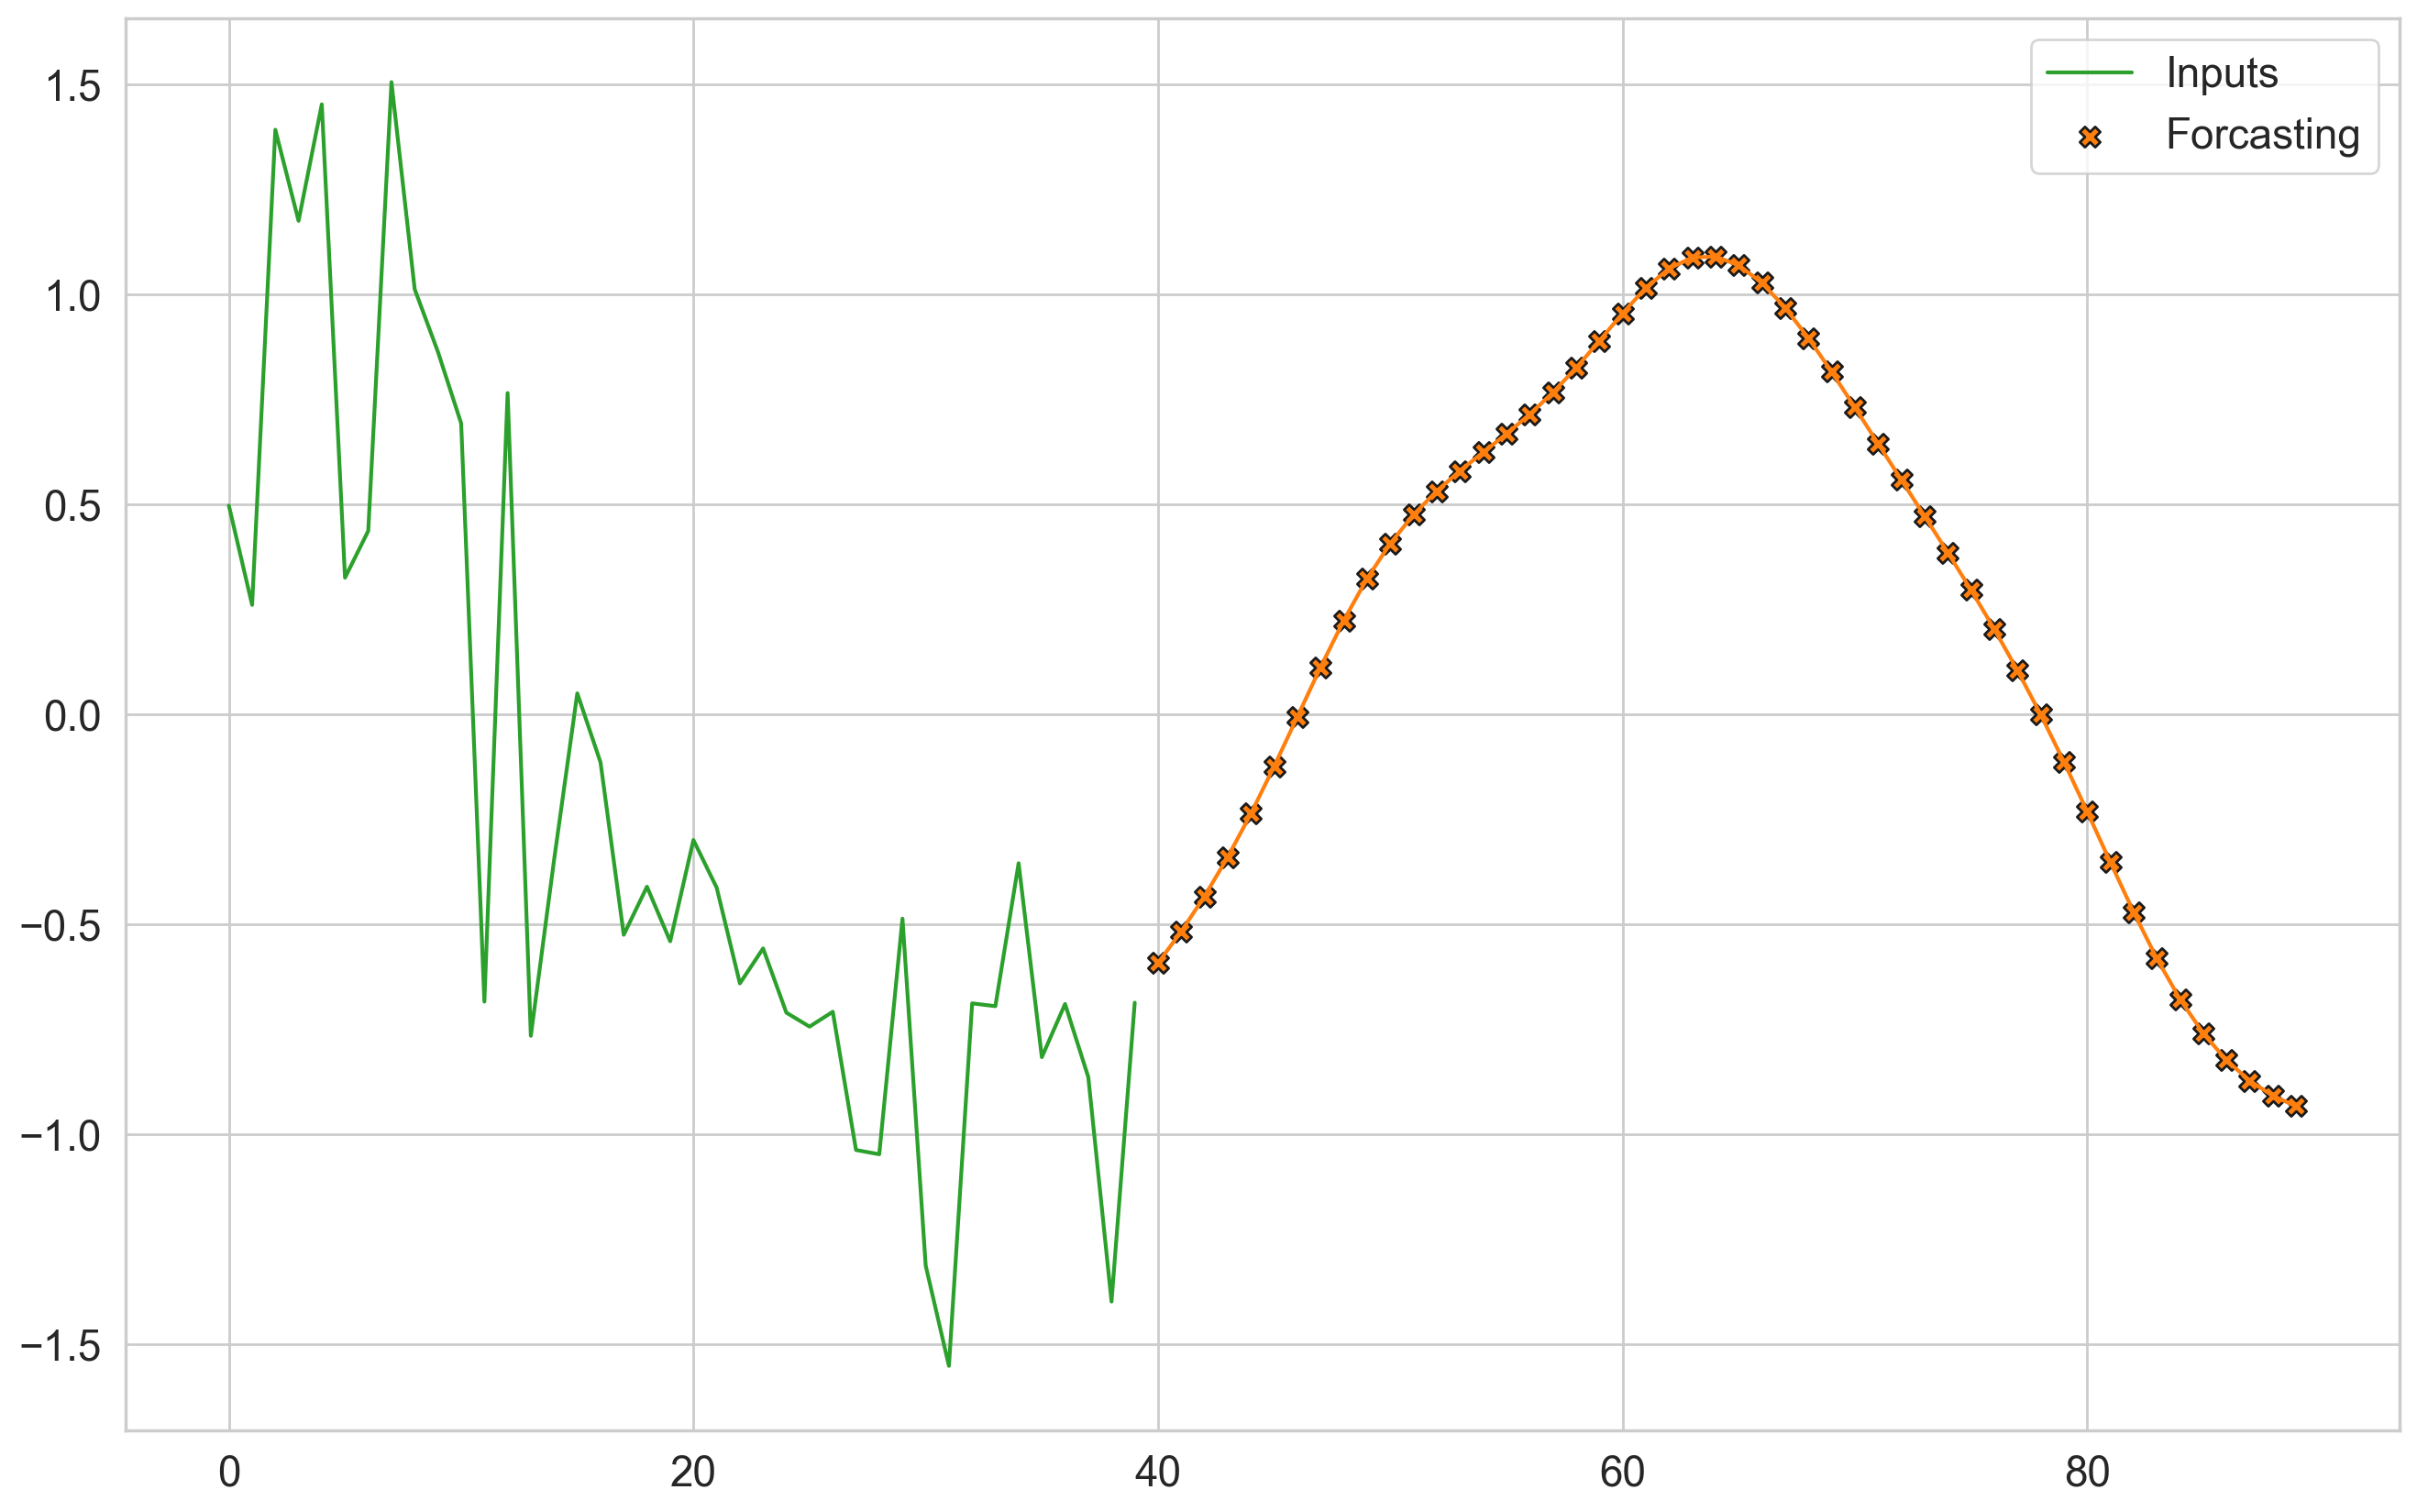

In [27]:
multi_params = window_params['multi-output'][0]

_, _ ,X_test, y_test = get_datasets(train, test, multi_params)

forcast_input = y_test[-1:, :, :]
feedback_model_40_40.out_steps = 50
forcasting = feedback_model_40_40(forcast_input)
forcasting = forcasting[0]

plt.plot([i for i in range( 40)], forcast_input[0], label = 'Inputs', c = '#2ca02c')
plt.plot([i for i in range(40, 90)], forcasting,c = '#ff7f0e' )
plt.scatter([i for i in range(40, 90)], forcasting, label = 'Forcasting', marker = 'X', edgecolors = 'k',
                   c = '#ff7f0e', s = 64)
plt.legend()
plt.show()


Both models performed exceptionally well in forecasting future values. While open_model_90 utilized real past values to predict the next 50 steps into the future, feedback_model_40 relied on its own predictions to generate future forecasts. Despite this difference, feedback_model_40 achieved performance on par with the open model, demonstrating its effectiveness.


# Conclusion
In summary, all models performed admirably in capturing the underlying patterns in the data. Models with historical context (warmup period > 1) exhibited superior generalization of the data’s patterns compared to those without such context. Notably, autoregressive models showed promising results, forecasting data with accuracy comparable to open-loop models.

However, several key considerations should be noted:

- **Project Focus:** This project aimed to demonstrate the process of handling time series data and using LSTM models for predictions. The sine wave dataset was particularly suitable due to its simplicity, which minimized the need for extensive data preprocessing. In practical scenarios, it's crucial to conduct exploratory data analysis (EDA) and perform preprocessing steps, such as data cleaning and transformation, to prepare the data for modeling.

- **Choice of Model:** Various models are available for time series forecasting. Experimenting with different types can help identify the model that performs best on a given dataset. For instance, this project utilized a single LSTM layer, but depending on the specific use case, adding more layers or exploring other architectures may be beneficial.

- **Hyperparameter Tuning:** This project did not explore hyperparameter tuning. Fine-tuning hyperparameters is essential to optimize model performance. Experimenting with different configurations can help identify the best model and hyperparameters for your specific dataset.

By considering these aspects, practitioners can better adapt these methods to their own data, leading to more accurate and reliable forecasting results.








# References
[Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651.)

[Time sereies forecasting | TensorFlow Core](https://www.tensorflow.org/tutorials/structured_data/time_series)